In [1]:
import argparse

import azureml.core
from azureml.core import Experiment,Workspace, Run
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.train.dnn import TensorFlow
from azureml.train.estimator import Estimator
from azureml.widgets import RunDetails
from collections import defaultdict
import cv2
import glob
import json
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from numpy import genfromtxt
from operator import concat
import os
import pandas as pd
import pickle
from PIL import Image, ImageFilter
#from pycocotools.coco import COCO
import pydot
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Flatten, Dropout, GaussianNoise, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD
from skimage import io as io
from skimage import exposure
from skimage.transform import resize, integral_image
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, daisy, hog, multiblock_lbp, haar_like_feature

from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_similarity_score, average_precision_score, f1_score, precision_score, hamming_loss, hinge_loss, recall_score
from sklearn.svm import SVC,LinearSVC
from sklearn.utils import check_random_state
import shutil
import tensorflow as tf
from time import time
import traceback
import timeit
import urllib.request
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from random import shuffle
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import itertools
from sklearn.decomposition import PCA
import seaborn as sns
import umap.umap_ as umap
#import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from skmultilearn.model_selection import iterative_train_test_split

Using TensorFlow backend.


In [16]:
print(azureml.core.VERSION)

'''
subscription_id = os.getenv("SUBSCRIPTION_ID", default="9bce0414-e6b9-4c79-b146-74018a4b09ac")
resource_group = os.getenv("RESOURCE_GROUP", default="Thesis")
workspace_name = os.getenv("WORKSPACE_NAME", default="Multi-label_classification")
workspace_region = os.getenv("WORKSPACE_REGION", default="westeurope")
'''
subscription_id = os.getenv("SUBSCRIPTION_ID", default="e8d26bef-c7d5-4ea0-a7e4-22fa5c586564")
resource_group = os.getenv("RESOURCE_GROUP", default="Thesis")
workspace_name = os.getenv("WORKSPACE_NAME", default="multi-label_classification_ent")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus2")

'''
subscription_id = os.getenv("SUBSCRIPTION_ID", default="3e9a2408-19d1-4ca2-bb63-339d47d3baaa")
resource_group = os.getenv("RESOURCE_GROUP", default="Thesis")
workspace_name = os.getenv("WORKSPACE_NAME", default="Multi-label_back-up")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus2")
'''
try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config()
    print("Workspace configuration succeeded. Skip the workspace creation steps below")
except Exception as e:
    print(e)
    print("Workspace not accessible. Change your parameters or create a new workspace below")
    
cpu_cluster_name = "cpuclusterD4"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print("Found existing cpucluster")
except ComputeTargetException:
    print("Creating new cpucluster")
    
    # Specify the configuration for the new cluster
    compute_config = AmlCompute.provisioning_configuration(vm_size="Standard_D4_v2",
                                                           min_nodes=0,
                                                           max_nodes=4)

    # Create the cluster with the specified name and configuration
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)
    
    # Wait for the cluster to complete, show the output log
    cpu_cluster.wait_for_completion(show_output=True)

gpu_cluster_name = "gpuclusterNC12"

# Verify that cluster does not exist already
try:
    gpu_cluster = ComputeTarget(workspace=ws, name=gpu_cluster_name)
    print("Found existing gpu cluster")
except ComputeTargetException:
    print("Creating new gpucluster")
    
    # Specify the configuration for the new cluster
    compute_config = AmlCompute.provisioning_configuration(vm_size="Standard_NC12",
                                                           min_nodes=0,
                                                           max_nodes=4)
    # Create the cluster with the specified name and configuration
    gpu_cluster = ComputeTarget.create(ws, gpu_cluster_name, compute_config)

    # Wait for the cluster to complete, show the output log
    gpu_cluster.wait_for_completion(show_output=True)


1.0.17
Wrote the config file config.json to: C:\Users\olivier.claessen\Desktop\A.I. thesis\aml_config\config.json
Workspace configuration succeeded. Skip the workspace creation steps below
Found existing cpucluster
Found existing gpu cluster


In [17]:
from azureml.core import Workspace

# Create the workspace using the specified parameters
ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,
                      create_resource_group = True,
                      exist_ok = True)
ws.get_details()

# write the details of the workspace to a configuration file to the notebook library
ws.write_config()

Wrote the config file config.json to: C:\Users\olivier.claessen\Desktop\A.I. thesis\aml_config\config.json


In [18]:
experiment_name = 'NeuralNetRand'
exp = Experiment(workspace=ws, name=experiment_name)

In [19]:
# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "gpuclusterNC12")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "Standard_NC12") #"STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target. just use it. gpuclusterNC12


In [20]:
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)
#ds.upload(src_dir='./data', target_path='data', overwrite=False, show_progress=True)

AzureBlob multilabstoragesttaiwwx azureml-blobstore-77b5704a-b7d1-4413-b1a8-b504fd99b2d0


In [21]:
script_folder = './coco-multi-label'
os.makedirs(script_folder, exist_ok=True)

In [8]:
with open("data/annotations/instances_train2014.json") as read_file:
    train = json.load(read_file)

with open("data/annotations/instances_val2014.json") as read_file:
    val = json.load(read_file)
'''
with open("data/annotations/instances_train2014.json") as read_file:
    instances = json.load(read_file)
with open("data/annotations/person_keypoints_train2014.json") as read_file:
    keypoints = json.load(read_file)
'''

'\nwith open("data/annotations/instances_train2014.json") as read_file:\n    instances = json.load(read_file)\nwith open("data/annotations/person_keypoints_train2014.json") as read_file:\n    keypoints = json.load(read_file)\n'

In [9]:
categories = train["categories"]
#print(categories)
train_images = train["images"]
val_images = val["images"]
train_annotations = train["annotations"]
val_annotations = val["annotations"]

In [10]:
train_categories = np.zeros(100, dtype=object)
val_categories = np.zeros(100, dtype=object)
#itemsets = [[] for i in range(581922)]
itemsets = defaultdict(list)
itemsets_val = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
unique_itemsets = []
for entry in itemsets:
    if(entry not in unique_itemsets):
        unique_itemsets.append(entry)
print(len(unique_itemsets))
for annotation in val_annotations:
    val_categories[annotation['category_id']] += 1
    itemsets_val[annotation['image_id']].append(annotation['category_id'])
unique_itemsets_val = []
for entry in itemsets_val:
    if(entry not in unique_itemsets_val):
        unique_itemsets_val.append(entry)
print(len(unique_itemsets_val))
train_categories = train_categories[train_categories != 0]
val_categories = val_categories[val_categories != 0]

82081
40137


Number of images in 2014 train: 82783
Number of images in 2014 val: 40504

Number of annotations in 2014 train: 604907
Number of annotations in 2014 val: 291875

Number of annotations/image in 2014 train: 7.307140354903785
Number of annotations/image in 2014 val: 7.206078412008691

Label density in 2014 train: 0.0913392544362973
Label density in 2014 val: 0.09007598015010863
dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])


1person: 185316
2bicycle: 4955
3car: 30785
4motorcycle: 6021
5airplane: 3833
6bus: 4327
7train: 3159
8truck: 7050
9boat: 7590
10traffic light: 9159
11fire hydrant: 1316
13stop sign: 1372
14parking meter: 833
15bench: 6751
16bird: 7290
17cat: 3301
18dog: 3774
19horse: 4666
20sheep: 6654
21cow: 5686
22elephant: 3905
23bear: 903
24zebra: 3685
25giraffe: 3596
27backpack: 6200
28umbrella: 7865
31handbag: 8778
32tie: 4497
33suitcase: 4251
34frisbee: 1862
35skis: 4698
36snowboard: 1960
37sports ball: 4392
38kite: 6560
39baseball bat: 2400
40baseball 

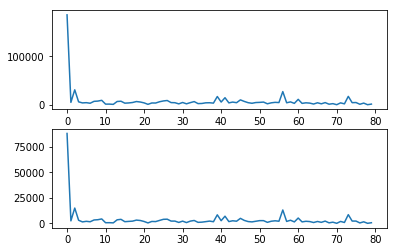


10 least used features 

[('hair drier', 135), ('toaster', 156), ('parking meter', 833), ('bear', 903), ('scissors', 1073), ('microwave', 1189), ('fire hydrant', 1316), ('stop sign', 1372), ('toothbrush', 1377)]



10 most used features 

[('handbag', 8778), ('traffic light', 9159), ('bowl', 10064), ('dining table', 11167), ('cup', 14513), ('bottle', 16983), ('book', 17315), ('chair', 27147), ('car', 30785), ('person', 185316)]




In [11]:
print("Number of images in 2014 train: "+str(len(train_images)))
print("Number of images in 2014 val: "+str(len(val_images)) +"\n")
print("Number of annotations in 2014 train: "+str(len(train_annotations)))
print("Number of annotations in 2014 val: "+str(len(val_annotations)) + "\n")
print("Number of annotations/image in 2014 train: "+str(len(train_annotations)/len(train_images)))
print("Number of annotations/image in 2014 val: " + str(len(val_annotations)/len(val_images)) + "\n")

print("Label density in 2014 train: "+str(len(train_annotations)/len(train_categories)/len(train_images)))
print("Label density in 2014 val: "+str(len(val_annotations)/len(val_categories)/len(val_images)))
print(train.keys())
print("\n")
#print(images[1:10])
#print("\n")
#print(annotations[1:10])
#print("\n")
#print(categories)
for i in range(0, len(train_categories)):
    print(str(categories[i]["id"]) + categories[i]["name"] + ": " + str(train_categories[i]))
    train_categories[i] = (categories[i]["name"], train_categories[i])
for i in range(0, len(val_categories)):
    print(str(categories[i]["id"]) + categories[i]["name"] + ": " + str(val_categories[i]))
    val_categories[i] = (categories[i]["name"], val_categories[i])
plt.figure(1)
plt.subplot(211)
plt.plot([i[1] for i in train_categories])
plt.subplot(212)
plt.plot([i[1] for i in val_categories])
plt.show()
train_categories = sorted(train_categories, key=lambda tup: tup[1], reverse=False)
val_categories = sorted(val_categories, key=lambda tup: tup[1], reverse=False)
print("\n10 least used features \n")
print(train_categories[0:9])
print("\n")
#print(val_categories[0:9])
print("\n10 most used features \n")
print(train_categories[-10:])
print("\n")
#print(val_categories[-10:])

In [105]:
corrected_ids = [0,1,2,3,4,5,6,7,8,9,10,11,0,12,13,14,15,16,17,18,19,20,21,22,23,24,0,25,26,0,0,27,28,29,30,31,32,33,34,35,36,37,38,39,40,0,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,0,61,0,0,62,0,63,64,65,66,67,68,69,70,71,72,73,0,74,75,76,77,78,79,80]
print(corrected_ids[0])

0


In [12]:
def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def zca_whitening_matrix(X):
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

def preProcessImage(img):
    img = np.asarray(img)
    #img = rgb2gray(img)
    #img = cv2.GaussianBlur(img,(5,5),0)
    #img = cv2.medianBlur(img,5)
    #img = cv2.bilateralFilter(img,9,75,75)
    #img = cv2.blur(img,(5,5))
    #kernel = np.ones((5,5),np.float32)/25
    #img = cv2.filter2D(img,-1,kernel)
    return img

def noisy(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations

def getPicture(image_id, path):
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    image_resized = resize(image, (104, 107), anti_aliasing=True)
    for annotation in annotations:
        try:
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    image_resized = np.asarray(image_resized)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,image_resized,bounded_annotations


def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    '''
    descs = daisy(gray_image, step=180, radius=8, rings=3, histograms=6,
                         orientations=8, visualize=False)
    '''
    descs = daisy(gray_image, step=180, radius=15, rings=3, histograms=8,
                         orientations=8, visualize=False)
    descs_num = descs.shape[0] * descs.shape[1]
    return descs.reshape(descs.size).tolist()

def calculateDoG(gray_image):
    blobs_dog = blob_dog(gray_image, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    return blobs_dog

def calculateSIFT(sift, gray_image):
    kp = sift.detect(gray_image,None)
    return kp

def calculateFeatures(imgs):
    #sift = cv2.xfeatures2d.SIFT_create()
    #detector = CENSURE()
    hog_features = []
    dog_features = []
    daisy_features = []
    harris_features = []
    lbp_features = []
    haar_features = []
    i = 0
    for img in imgs:
        hog_features.append(calculateHogFeatures(img,8,12,1))
        daisy_features.append(calculateDaisyFeatures(img))
        int_img = integral_image(img)
        lbp_features.append(multiblock_lbp(int_img, 0, 0, 30, 30))
        #haar_features.append(haar_like_feature(int_img, 0, 0, 24, 24))
        #shape_index_features.append(shape_index(img))
        #dog_features.append(calculateDoG(img))
        #harris_features.append(corner_peaks(corner_harris(img), min_distance=5))
        #sift_features.append(calculateSIFT(sift, img))
        print(i)
        i += 1
    return  hog_features, daisy_features, lbp_features#, haar_features

def svmFit(x_train, y_train):
    print("Fitting the classifier to train")
    #t0 = time()
    '''
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    '''
    clf = OneVsRestClassifier(LinearSVC())
    #clf = OneVsRestClassifier(SVC(kernel='poly'))
    clf = clf.fit(x_train, y_train)
    #print("Completed in %0.3fs" % (time() - t0))
    #print("Best estimator found by grid search:")
    #print(clf.best_estimator_)
    return clf

def saveModel(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
    
def loadModel(filename):
    print("loading file...")
    joblib.load(filename)
    print("Model loaded")
    
def svmPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_micro:", precision_score(y_test, y_pred, average = 'micro'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_micro:", recall_score(y_test, y_pred, average = 'micro'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    
def randomForestFit(x_train, y_train, estimators):
    print("Fitting the classifier to train")
    #t0 = time()
    rf = RandomForestClassifier(n_estimators=estimators)
    rf.fit(x_train, y_train);
    #print("Completed in %0.3fs" % (time() - t0))
    return rf

def rfPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    errors = abs(y_pred - y_test)
    print("Errors:", errors)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_weighted:", precision_score(y_test, y_pred, average = 'weighted'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_weighted:", recall_score(y_test, y_pred, average = 'weighted'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)

def constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, dropout, num_classes, x_train):
    model = Sequential()

    model.add(Conv2D(layer_size, (kernel_size, kernel_size), input_shape=x_train.shape[1:]))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for l in range(conv_layer-1):
        model.add(Conv2D(layer_size, (kernel_size, kernel_size)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Flatten())

    for j in range(dense_layer):
        model.add(Dense(dense_size))
        model.add(Activation('relu'))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])

    return model
    
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def splitPreprocessing(splits, data_folder, path):
    labels = []
    features = np.asarray([[],[]])
    for split in splits:
        bboxes = getBoundingBoxesAnnotations(split, os.path.join(data_folder, path))
        splitfeatures = calculateFeatures(bboxes[0])
        features = np.append(features, splitfeatures,1)
        labels.extend(bboxes[1])
    return labels, features.tolist()

def non_max_suppression_slow(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    no_overlap = []
 
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        no_overlap.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    return boxes[pick].astype("int")

def IoU(box_1,box_2):
    x_a = max(box_1[0],box_2[0])
    y_a = max(box_1[1],box_2[1])
    x_b = min(box_1[2],box_2[2])
    y_b = min(box_1[3],box_2[3])
    
    overlap = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
    box_1_area = (box_1[2] - box_1[0] + 1) * (box_1[3] - box_1[1] + 1)
    box_2_area = (box_2[2] - box_2[0] + 1) * (box_2[3] - box_2[1] + 1)
    IoU = overlap/float(box_1_area + box_2_area + overlap)
    
    return IoU

def pyramid(image, scale=1.5, minSize=(30, 30)):
    yield image
 
    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
 
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image

def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            
def slidingWindow(img):
    image = cv2.imread('data/' + path + img +'.jpg')
    (winW, winH) = (48, 48)
    for resized in pyramid(image, scale=1.5):
        for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
            if window.shape[0] != winH or window.shape[1] != winW:
                continue
            box = preProcessImage(window)
            features = calculateFeatures([box])
            prediction = svmHOG.predict(features[0])
            print(prediction)
            clone = resized.copy()
            #fig,ax = plt.subplots(1)
            cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
            cv2.imshow("Window", clone)
            cv2.waitKey(1)
            time.sleep(1)
            
def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list

def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

data_folder = 'data'

path = "train2014/COCO_train2014_"
valpath = "val2014/val2014/COCO_val2014_"
category = "category_id"

In [22]:
labels = np.asarray(list(itemsets.values()))
keys = np.asarray(list(itemsets.keys()))
multilabel_binarizer = MultiLabelBinarizer()
binarized = multilabel_binarizer.fit_transform(labels)

rand_sets,rand_images = random_sets(labels,keys,100)
labels_train = np.array(binarized)


In [140]:
instances_train = np.array([[key] for key in keys])
#labels_train = [to_categorical(labelset) for labelset in labels] #np.array([label for labelset in labels for label in labelset])
#labels_train = np.asarray(labels_train)
#[label for labels in l for label in labels]

In [ ]:
images = []
for [instance] in instances_train:
    bbox = getBoundingBoxesPicture(instance,path)
    images.append(bbox)

In [141]:
#image_ids_all, images_all, bounded_annotations_all  = list(zip(*images))
#image_ids_all_list = list(itertools.chain.from_iterable(image_ids_all))
images_all_list = list(itertools.chain.from_iterable(images_all))
bounded_annotations_all_list = list(itertools.chain.from_iterable(bounded_annotations_all))

NameError: name 'images_all' is not defined

In [ ]:
#images_all_list = np.array(images_all_list)
images_all_np = np.array(images_all_list[0])
for image in images_all_list[1:]:
    np.concatenate((images_all_np,np.array(image)))

In [19]:
categories_subset = [2,3,4,5,6,7,8,9]

bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
imgs = bbox[0]
y_train = bbox[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


zero-size array to reduction operation minimum which has no identity


In [85]:
nsamples, nx, ny = images_all_np.shape
imgs_flat = imgs.reshape((nsamples,nx*ny))

ValueError: not enough values to unpack (expected 3, got 2)

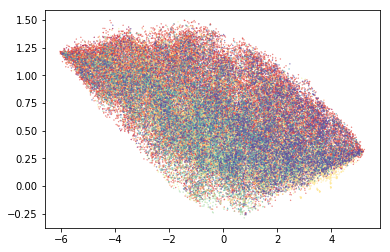

In [21]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=80,
    random_state=42,
).fit_transform(imgs_flat)
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=bounded_annotations_all, s=0.1, cmap='Spectral')
#kmeans_labels = cluster.KMeans(n_clusters=5).fit_predict(imgs_flat)
#plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y_train, s=0.1, cmap='Spectral')
#lowd_train = PCA(n_components=50).fit_transform(imgs_flat)
#hdbscan_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=500).fit_predict(lowd_train)

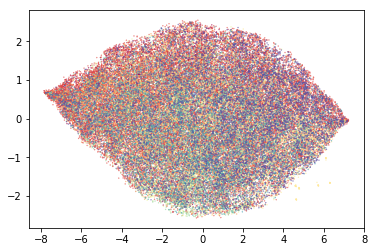

In [22]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(imgs_flat)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y_train, s=0.1, cmap='Spectral');

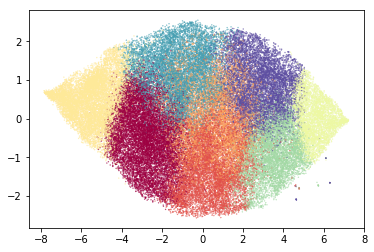

In [23]:
kmeans_labels = cluster.KMeans(n_clusters=80).fit_predict(imgs_flat)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');

In [24]:
clustering_rand_score = adjusted_rand_score(y_train, kmeans_labels),
clustering_MI = adjusted_mutual_info_score(y_train, kmeans_labels)


c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


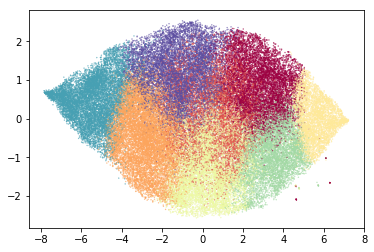

In [25]:
lowd_train = PCA(n_components=50).fit_transform(imgs_flat)
kmeans_labels_pca = cluster.KMeans(n_clusters=80).fit_predict(lowd_train)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels_pca, s=0.1, cmap='Spectral');
#hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_mnist)

In [ ]:
def findValueDictionary(dict,key,value, returnkey):
    for entry in dict:
        if entry[key] == value:
            return entry[returnkey]

image_id_string = str(image_id).zfill(12)
image = np.array(Image.open('data/train2014/COCO_train2014_'+ image_id_string +'.jpg'), dtype=np.uint8)

colors = np.random.random((len(categories)+10, 3))
i=0
bbox_list = []
item_list = []
fig,ax = plt.subplots(1)
ax.imshow(image)
for item in items:
    label = findValueDictionary(categories, 'id', item['category_id'], 'name')
    rect = patches.Rectangle((item['bbox'][0], (item['bbox'][1])), item['bbox'][2], item['bbox'][3],linewidth=1,edgecolor=colors[item['category_id']-1],facecolor='none', label= label)
    ax.add_patch(rect)
    bbox_list.append(rect)
    item_list.append(item['category_id'])
#print(items)
plt.figure(figsize=(3,4))
plt.legend(handles=bbox_list)
plt.show()

In [13]:

'''
#testsplits = list(chunks(dummy_annotations, 50))
#labels, features = splitPreprocessing(testsplits, data_folder, path)

'''

categories_subset = [2,52]
bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
bbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))
imgs = bbox[0]
imgs_val = bbox_val[0]
y_train = bbox[1]
y_test = bbox_val[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))
    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))
    imgs_val = np.concatenate((imgs_val,bbox_val[0]))
    y_test = np.concatenate((y_test,bbox_val[1]))




c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [174]:
iterative_x_train, iterative_y_train, iterative_x_test, iterative_y_test = iterative_train_test_split(instances_train, labels_train, test_size = 0.999)
iterative_x_val, iterative_y_val, iterative_x_test, iterative_y_test = iterative_train_test_split(iterative_x_test, iterative_y_test, test_size = 0.999)

In [241]:
iterative_split_train = []
for instance in iterative_x_train:
    iterative_split_train.append(itemsets[instance[0]])
iterative_split_val = []
for instance in iterative_x_test:
    iterative_split_val.append(itemsets[instance[0]])

[58, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[58, 67, 1]
[58, 1, 1, 1, 1, 31, 1]
[58, 44, 44, 1, 1, 49, 49, 53, 56, 47, 62, 67, 1, 44]
[58, 58, 58, 44, 67, 1, 1, 1, 1, 1, 47, 48, 50, 50, 51, 51, 51, 51, 51, 44, 44, 44, 47, 50, 50, 50, 50, 51, 58, 58, 58, 67, 1, 1, 1, 1, 1, 57, 1, 1, 58, 58, 58, 58, 58, 58, 58]
[58]
[58, 54]
[18, 1, 62, 62]
[18, 20, 20, 31, 31, 1, 1, 1, 1, 1, 31, 31, 31, 31, 1, 1, 1, 1, 1, 1, 1, 1, 77]
[18, 1, 31, 27, 15]
[18, 38, 38, 38, 1, 1, 1, 1, 1, 1, 9, 9, 9, 31, 1, 1, 1, 1, 1, 1, 28, 1]
[18, 44, 67, 1, 8, 47, 50, 50, 51, 51, 51, 51, 18, 3, 31, 44]
[18, 1, 1, 1, 1, 1, 34, 1, 62]
[18, 62, 67, 84, 47, 62, 63, 47, 62, 84, 84, 47]
[18, 62, 62, 63, 1, 1, 1, 31, 1, 18, 84, 84]
[18, 62, 63, 63, 1, 1, 1, 75, 75, 84, 84, 84, 1, 67, 84, 84, 84, 84, 84, 84, 84, 84, 75, 84, 75, 75]
[18, 63, 1, 85, 67]
[18, 18, 18, 18, 18, 18, 18, 44, 1, 1, 31, 18, 1, 1, 1]
[18, 9, 9, 9, 1, 1, 18]
[18, 18, 1, 1, 15, 1]
[18, 20, 20, 20, 15, 1, 1, 1, 15, 62, 1, 1, 1, 1, 1, 1, 1, 1, 62, 62, 62, 62, 62, 

1person: 1949
2bicycle: 64
3car: 423
4motorcycle: 59
5airplane: 36
6bus: 53
7train: 30
8truck: 88
9boat: 81
10traffic light: 90
11fire hydrant: 12
13stop sign: 13
14parking meter: 11
15bench: 66
16bird: 186
17cat: 62
18dog: 238
19horse: 139
20sheep: 59
21cow: 40
22elephant: 44
23bear: 10
24zebra: 31
25giraffe: 31
27backpack: 65
28umbrella: 59
31handbag: 96
32tie: 90
33suitcase: 81
34frisbee: 37
35skis: 54
36snowboard: 30
37sports ball: 59
38kite: 65
39baseball bat: 38
40baseball glove: 30
41skateboard: 33
42surfboard: 41
43tennis racket: 29
44bottle: 206
46wine glass: 60
47cup: 160
48fork: 58
49knife: 88
50spoon: 58
51bowl: 101
52banana: 105
53apple: 31
54sandwich: 59
55orange: 48
56broccoli: 52
57carrot: 39
58hot dog: 20
59pizza: 91
60donut: 93
61cake: 60
62chair: 218
63couch: 62
64potted plant: 121
65bed: 28
67dining table: 119
70toilet: 28
72tv: 56
73laptop: 30
74mouse: 15
75remote: 45
76keyboard: 21
77cell phone: 55
78microwave: 15
79oven: 28
80toaster: 5
81sink: 43
82refrigerator:

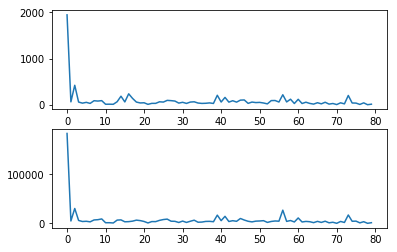

In [27]:
iterative_train_categories = np.zeros(100, dtype=object)
iterative_val_categories = np.zeros(100, dtype=object)
for subset in iterative_split_train:
    print(subset)
    for item in subset:
        iterative_train_categories[item] += 1

for subset in iterative_split_val:
    for item in subset:
        iterative_val_categories[item] += 1

iterative_train_categories = iterative_train_categories[iterative_train_categories != 0]
iterative_val_categories = iterative_val_categories[iterative_val_categories != 0]
for i in range(0, len(iterative_train_categories)):
    print(str(categories[i]["id"]) + categories[i]["name"] + ": " + str(iterative_train_categories[i]))
    iterative_train_categories[i] = (categories[i]["name"], iterative_train_categories[i])

for i in range(0, len(iterative_val_categories)):
    print(str(categories[i]["id"]) + categories[i]["name"] + ": " + str(iterative_val_categories[i]))
    iterative_val_categories[i] = (categories[i]["name"], iterative_val_categories[i])

plt.figure(1)
plt.subplot(211)
plt.plot([i[1] for i in iterative_train_categories])
plt.subplot(212)
plt.plot([i[1] for i in iterative_val_categories])

In [28]:
mskf = MultilabelStratifiedKFold(n_splits=100, random_state=0)

for train_index, test_index in mskf.split(instances_train, labels_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_split, test_split = instances_train[train_index], instances_train[test_index]
    y_train_split, y_test_split = labels_train[train_index], labels_train[test_index]

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [   49   167   223   308   368   411   498   506   535   666   805   819
   926  1006  1154  1295  1340  1498  1706  1715  1752  1790  1922  1980
  2135  2387  2486  2596  2616  2895  3021  3320  3625  3688  3787  3846
  3927  3941  4056  4072  4096  4407  4517  4537  4585  4697  4850  4899
  4970  5065  5145  5392  5497  5624  5651  5734  5887  6041  6170  6492
  6597  6710  6830  6957  6961  7004  7104  7243  7396  7542  7691  7797
  7838  7952  7989  8003  8172  8314  8543  8573  8590  8754  8780  8807
  8981  9062  9098  9239  9423  9563  9679  9752  9800  9856  9866  9908
 10108 10113 10304 10472 10483 10547 10670 10848 10865 10960 11109 11154
 11230 11260 11435 11458 11608 11672 11744 11767 11920 12016 12168 12260
 12367 12450 12557 12661 12761 12900 13018 13118 13220 13321 13430 13537
 13644 13746 13853 13959 13974 14015 14344 14363 14555 14878 15112 15119
 15238 15249 15353 15439 15495 15613 15875 16101 16198 16207 16350 16

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [   26   135   175   230   241   310   350   415   448   547   674   718
   826   918  1013  1015  1162  1354  1497  1502  1716  1721  1773  1928
  2144  2232  2389  2636  2656  2823  3095  3185  3357  3368  3370  3466
  3651  3675  3793  3903  3971  4009  4092  4121  4234  4394  4482  4540
  4633  4641  4824  4845  4853  5010  5022  5397  5407  5525  5555  5675
  5681  5943  6257  6260  6272  6296  6339  6382  6391  6451  6470  6555
  6678  6793  6920  7061  7198  7353  7492  7649  7799  7948  8046  8074
  8092  8208  8296  8418  8466  8514  8571  8582  8716  8734  8747  8821
  8882  8958  9207  9410  9412  9504  9532  9783  9918 10077 10366 10450
 10557 10673 10806 10939 11077 11228 11272 11379 11406 11577 11591 11684
 11737 11893 11992 12107 12199 12314 12419 12522 12625 12724 12807 12916
 13006 13105 13210 13315 13420 13525 13627 13734 13841 13940 13970 13972
 14088 14432 14692 14694 14750 14772 14778 14794 15074 15152 15266 15

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [  338   435   568   575   662   713   867  1050  1214  1269  1302  1377
  1552  1753  1797  1933  1972  2066  2072  2097  2171  2397  2431  2604
  2625  2657  2676  2868  2924  3090  3143  3362  3387  3669  3740  3982
  4078  4110  4134  4172  4182  4197  4224  4263  4314  4427  4449  4566
  4599  4675  4740  4939  5047  5136  5155  5187  5437  5526  5606  5671
  5732  5874  5946  6110  6135  6217  6222  6341  6387  6474  6544  6564
  6692  6807  6937  6964  6980  7070  7154  7211  7369  7371  7513  7666
  7810  7964  8038  8072  8103  8171  8205  8328  8357  8589  8592  8799
  9006  9044  9095  9228  9300  9437  9487  9553  9626  9701  9710  9850
  9885 10053 10145 10196 10558 10680 10694 10742 10809 10944 11084 11116
 11242 11418 11506 11592 11748 11759 11822 11898 12036 12083 12181 12245
 12382 12459 12592 12700 12802 12894 12956 13041 13138 13248 13347 13457
 13564 13665 13771 13775 13881 14030 14077 14286 14313 14503 14679 14

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [   58    90   138   180   235   319   357   421   552   689   850   882
   957  1020  1035  1174  1356  1521  1657  1730  1763  1905  1944  2153
  2400  2404  2441  2485  2641  2737  2819  2986  3060  3204  3235  3430
  3464  3494  3507  3562  3619  3729  3802  3891  3910  3978  4150  4280
  4386  4453  4518  4835  4971  4997  5193  5212  5338  5424  5463  5465
  5685  5702  5920  5963  5993  6278  6304  6344  6394  6478  6571  6695
  6812  6941  7077  7220  7374  7515  7672  7693  7817  7966  8354  8393
  8548  8555  8692  8843  8884  8960  9092  9138  9211  9393  9482  9538
  9577  9604  9777  9837  9913  9944  9994 10071 10274 10335 10397 10495
 10617 10744 10815 10876 10990 11013 11164 11328 11499 11662 11821 11973
 11994 12093 12151 12294 12372 12448 12570 12659 12786 12858 12987 13016
 13115 13219 13325 13431 13534 13642 13750 13851 13958 14000 14069 14187
 14293 14341 14647 14924 15022 15100 15211 15240 15318 15400 15598 15

TRAIN: [    0     1     2 ... 82077 82078 82079] TEST: [   32   206   403   409   495   576   628   746   778   815   921   943
  1095  1128  1267  1429  1441  1450  1584  1624  1829  2045  2048  2277
  2384  2450  2476  2517  2727  2818  2871  2993  3239  3327  3335  3354
  3520  3728  3877  3907  3919  3989  4141  4206  4282  4397  4460  4514
  4529  4681  4892  4961  5110  5252  5368  5429  5474  5598  5666  5858
  5989  6024  6078  6147  6148  6280  6300  6310  6357  6418  6500  6608
  6725  6840  6972  7118  7252  7411  7448  7557  7706  7856  8120  8188
  8271  8404  8464  8467  8510  8540  8639  8702  8881  8943  9140  9165
  9172  9223  9464  9580  9737  9833  9945 10003 10045 10101 10409 10425
 10463 10477 10563 10689 10820 10953 10973 11107 11257 11389 11426 11600
 11675 11713 11761 11877 11919 12137 12240 12337 12441 12540 12645 12729
 12831 12935 12991 13091 13143 13193 13297 13402 13508 13614 13722 13825
 13929 14044 14138 14309 14330 14358 14437 14557 14642 14780 14984 15

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [   33   214   271   291   386   388   497   630   752   780   807   944
  1096  1181  1268  1430  1563  1626  1832  1873  2049  2216  2284  2469
  2518  2719  2728  2843  2889  3038  3171  3205  3219  3384  3406  3460
  3660  3687  3827  3909  3915  4120  4435  4542  4658  4676  4716  4830
  5031  5068  5444  5636  5760  5799  5892  5905  5998  6048  6114  6186
  6598  6677  6699  6947  7046  7049  7054  7090  7226  7382  7530  7606
  7682  7819  7826  7981  8117  8179  8255  8350  8449  8645  8687  8829
  8869  8891  8920  9064  9142  9445  9500  9524  9602  9720  9870 10021
 10033 10099 10505 10630 10648 10688 10761 10891 11035 11178 11305 11349
 11441 11475 11519 11691 11721 11722 11843 11866 12001 12111 12220 12318
 12415 12505 12614 12721 12816 12921 12982 13001 13081 13183 13288 13389
 13471 13500 13602 13709 13816 13919 14101 14122 14285 14376 14403 14408
 14444 14510 14685 14735 14748 14993 15116 15188 15319 15376 15386 15

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [   18   108   427   555   556   560   699   856   970  1014  1042  1184
  1368  1406  1526  1689  1742  1776  1965  1969  2125  2127  2162  2227
  2260  2382  2419  2648  2815  2837  2899  3027  3134  3186  3418  3421
  3567  3601  3722  3839  3848  4106  4402  4410  4462  4635  4679  4691
  4731  4876  4895  4924  5116  5286  5372  5569  5610  5670  5672  5769
  5792  5872  6166  6238  6338  6362  6444  6526  6636  6756  6882  7009
  7036  7112  7161  7267  7290  7314  7454  7600  7752  7760  7900  8093
  8168  8199  8330  8554  8654  8690  8840  8921  9083  9085  9116  9182
  9217  9381  9541  9676  9749  9919  9921  9952 10030 10036 10088 10257
 10518 10640 10752 10771 10901 11021 11045 11048 11194 11361 11534 11697
 11828 11855 11984 12018 12048 12053 12184 12278 12398 12474 12577 12684
 12776 12888 12965 13061 13165 13269 13371 13480 13585 13690 13798 13904
 14090 14337 14459 14646 14704 14825 14863 14923 14983 15019 15156 15

 81382 81412 81483 81499 81671 81794 81925 81986]
TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [    9   261   298   300   417   496   549   705   862   960   985  1065
  1130  1303  1471  1664  1869  1891  1902  2031  2090  2220  2330  2561
  2601  2768  2874  2984  3004  3071  3160  3211  3365  3442  3490  3565
  3650  3795  3873  3887  4055  4387  4404  4424  4803  4825  4989  5339
  5665  5713  5782  5898  5972  6001  6189  6455  6535  6651  6673  6730
  6778  6893  7023  7178  7331  7476  7533  7622  7779  7929  8008  8113
  8115  8165  8319  8321  8523  8539  8750  8758  8767  8825  8987  9243
  9281  9396  9556  9745  9795  9817  9835 10107 10169 10194 10735 10847
 11049 11051 11121 11199 11209 11345 11346 11365 11397 11404 11545 11699
 11774 11858 11861 12028 12138 12233 12327 12428 12528 12547 12635 12736
 12832 12939 13023 13129 13232 13330 13443 13549 13656 13756 13861 13964
 13983 14017 14205 14212 14325 14425 14551 14568 14867 15036 15075 15110
 15114 15262 15433 

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [   38   190   259   367   452   476   594   609   753   919   975  1072
  1219  1239  1260  1309  1325  1407  1602  1802  2018  2156  2240  2253
  2254  2443  2488  2704  2808  2922  3081  3358  3394  3456  3586  3654
  3656  3695  3774  3825  3905  3967  4086  4102  4114  4178  4426  4505
  4521  4555  4718  4831  4991  5069  5159  5236  5343  5406  5532  5643
  5909  5981  6027  6046  6076  6188  6282  6615  6732  6847  6914  6978
  7084  7124  7157  7264  7304  7418  7431  7565  7716  7863  7932  8119
  8211  8428  8602  8809  8934  9048  9074  9114  9129  9247  9347  9632
  9639  9717  9809  9906  9987 10126 10579 10849 10851 11094 11152 11207
 11246 11317 11377 11424 11599 11742 11756 11804 11910 11918 11959 12026
 12073 12177 12252 12389 12446 12591 12672 12754 12864 13051 13153 13256
 13361 13465 13570 13678 13786 13888 14242 14261 14353 14420 14569 14639
 14859 14920 15005 15117 15136 15212 15395 15578 15942 16054 16249 16

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [   54   342   582   688   739   852   899   997  1023  1088  1156  1170
  1305  1355  1512  1518  1610  1724  1822  1939  2140  2151  2354  2374
  2412  2643  2753  2812  2906  2977  3023  3030  3079  3216  3238  3341
  3448  3477  3690  3751  3766  3938  4154  4161  4191  4213  4245  4309
  4330  4443  4461  4600  4728  4802  4902  4996  5154  5244  5269  5329
  5412  5515  5593  5740  5796  5815  6031  6044  6239  6437  6463  6517
  6628  6745  6869  6974  6996  7045  7143  7294  7442  7507  7589  7739
  7886  7991  8081  8206  8227  8385  8516  8588  8604  8644  8709  8835
  9071  9344  9363  9452  9630  9663  9758  9938 10054 10437 10537 10668
 10800 10933 11066 11091 11156 11219 11237 11391 11466 11472 11572 11728
 11889 11950 12052 12129 12225 12329 12360 12445 12542 12643 12741 12842
 12932 13048 13155 13254 13358 13395 13467 13573 13677 13785 13890 14280
 14300 14468 14507 14527 14534 14576 14773 14850 14898 15401 15545 15

 81588 81659 81743 81789 81821 81864 81944 82029 82031]
TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [   50   119   159   170   311   413   446   545   677   810   829   845
  1007  1115  1165  1346  1419  1458  1514  1717  1929  1963  2078  2137
  2310  2391  2623  2876  2901  3104  3375  3392  3539  3613  3985  4015
  4034  4297  4334  4480  4563  4611  4733  4780  5258  5311  5341  5352
  5491  5699  5831  5850  5965  5978  6102  6116  6404  6454  6596  6738
  6808  7100  7119  7125  7253  7260  7273  7421  7472  7566  7717  7853
  7862  8013  8026  8075  8091  8222  8249  8320  8484  8620  8658  8739
  8867  8927  9199  9285  9454  9476  9518  9521  9533  9772  9813  9854
 10075 10123 10299 10603 10760 10816 10890 10949 10989 11037 11179 11295
 11351 11521 11637 11688 11823 11841 11914 11974 12002 12012 12086 12178
 12271 12396 12489 12561 12689 12753 12847 13026 13127 13233 13334 13440
 13543 13655 13760 13865 14176 14516 14546 14613 14669 14709 14789 14800
 14844 14872 

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [    8   155   176   227   309   397   420   551   673   683   735   822
   979  1012  1158  1276  1288  1352  1511  1524  1719  1756  1831  1926
  2067  2146  2256  2395  2634  2816  2928  2998  3091  3371  3501  3510
  3646  3678  3858  3973  4124  4533  4764  4805  4857  4903  5089  5283
  5317  5505  5527  5553  5706  5834  5845  6004  6061  6099  6427  6468
  6746  7008  7039  7164  7183  7330  7422  7474  7478  7564  7624  7778
  7885  7931  8039  8142  8285  8458  8511  8731  8903  8956  9162  9196
  9315  9362  9391  9517  9536  9766  9825  9875  9943 10070 10084 10095
 10279 10342 10413 10512 10591 10634 10765 10894 10942 11041 11157 11186
 11353 11524 11694 11847 12009 12077 12187 12247 12377 12487 12564 12668
 12758 12889 13106 13213 13309 13423 13523 13633 13670 13740 13845 13944
 14192 14202 14298 14381 14454 14590 14651 14799 14886 14999 15044 15103
 15141 15292 15338 15373 15483 15503 15784 15808 15985 15999 16221 16

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [  204   221   385   436   527   585   687   840   908   990  1018  1171
  1357  1393  1418  1523  1577  1710  1725  1857  1934  2027  2039  2123
  2149  2417  2480  2642  2798  2847  2877  2884  2991  3135  3161  3381
  3405  3488  3558  3804  3992  4037  4050  4067  4222  4390  4520  4530
  4652  4660  4673  4877  4913  4926  4982  5098  5125  5337  5506  5590
  5788  5849  5919  6059  6111  6268  6287  6329  6375  6448  6531  6642
  6767  6798  6885  7013  7176  7315  7457  7607  7732  7765  7845  7905
  7906  8060  8108  8402  8854  8999  9013  9079  9112  9159  9218  9253
  9390  9403  9506  9634  9677  9802  9964 10122 10206 10247 10268 10355
 10429 10642 10722 10826 10963 11099 11118 11274 11442 11454 11558 11616
 11770 11930 12099 12201 12317 12425 12513 12608 12723 12827 12922 12960
 13059 13160 13259 13366 13474 13478 13577 13681 13791 13895 14042 14053
 14132 14178 14265 14342 14391 14521 14633 14641 14667 14671 14824 14

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [   77   158   203   290   537   558   565   714   896  1199  1421  1466
  1811  1875  1879  1927  2102  2105  2251  2344  2413  2483  2572  2738
  2777  2862  2994  3062  3154  3218  3351  3416  3434  3549  3557  3718
  3782  3922  4035  4170  4275  4302  4329  4392  4522  4567  4592  4669
  4726  4790  4886  5105  5130  5266  5358  5373  5485  5585  5766  5853
  6101  6143  6235  6246  6405  6509  6513  6623  6676  6742  6844  6863
  6990  7137  7287  7435  7582  7728  7881  8019  8101  8253  8276  8372
  8426  8597  8663  8682  8761  8916  8945  9136  9407  9436  9511  9666
  9711  9764 10012 10177 10193 10351 10452 10526 10647 10651 10669 10788
 10830 10914 11059 11110 11211 11325 11373 11387 11548 11710 11809 11879
 12034 12088 12172 12258 12361 12453 12583 12692 12780 12855 12979 13079
 13177 13284 13386 13497 13600 13708 13812 13914 14048 14049 14215 14259
 14282 14369 14419 14430 14631 14635 14833 14921 14959 15138 15340 15

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [   60   156   426  1000  1111  1114  1202  1282  1291  1292  1335  1454
  1607  1663  1744  1867  1901  1946  2080  2245  2320  2358  2411  2545
  2547  2742  2756  2772  2814  2841  2925  3115  3190  3444  3547  3615
  3657  3958  3964  4099  4221  4242  4344  4465  4614  4625  4765  4797
  4807  4812  5018  5083  5279  5350  5376  5520  5661  5770  5931  5953
  6039  6154  6157  6305  6347  6407  6488  6572  6591  6705  6821  6950
  7093  7228  7230  7389  7416  7475  7497  7535  7685  7829  7984  8043
  8047  8151  8302  8517  8535  8542  8552  8701  8742  8964  8990  9166
  9202  9212  9215  9331  9540  9793  9796  9985 10080 10217 10271 10324
 10390 10487 10592 10604 10729 10866 10992 11000 11145 11310 11390 11485
 11633 11644 11805 11908 11962 12161 12262 12376 12461 12571 12681 12787
 12885 13020 13120 13171 13226 13326 13436 13539 13647 13751 13859 13963
 14059 14085 14096 14190 14251 14281 14380 14529 14625 14666 14901 14

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [  174   201   220   233   262   286   500   510   620   625   858  1218
  1329  1339  1495  1703  1900  1916  2032  2136  2203  2217  2238  2301
  2379  2546  2620  2775  2796  2811  2855  2913  2979  3016  3058  3073
  3308  3333  3467  3537  3564  3623  3644  3890  4095  4117  4368  4369
  4442  4485  4589  4650  4836  4852  5092  5172  5247  5305  5319  5349
  5560  5609  5652  5763  5817  5883  5900  6091  6321  6587  6706  6820
  6951  7095  7233  7341  7388  7417  7536  7549  7647  7684  7830  7985
  8061  8124  8175  8338  8348  8560  8770  8871  9000  9254  9325  9485
  9488  9562  9570  9851 10131 10228 10331 10479 10717 10853 10925 10981
 11136 11158 11288 11470 11503 11566 11594 11612 11636 11789 11951 12025
 12134 12242 12338 12439 12538 12640 12739 12839 12946 13052 13151 13255
 13360 13464 13574 13676 13783 13887 13985 14074 14256 14288 14407 15055
 15194 15207 15221 15327 15570 15676 15932 15933 15941 15992 16027 16

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [   37   317   540   671   995  1040  1055  1150  1169  1257  1324  1488
  1590  1640  1662  1700  1840  1853  1909  2011  2060  2104  2120  2372
  2598  2628  2688  2707  2806  2844  2893  2963  2997  3020  3175  3183
  3400  3451  3505  3530  3595  3836  3856  4087  4289  4349  4350  4479
  4526  4683  4707  4801  4888  5113  5306  5366  5583  5592  5840  5857
  6151  6245  6313  6358  6422  6503  6617  6734  6852  6855  6983  7015
  7026  7130  7271  7427  7574  7680  7721  7872  8140  8286  8439  8469
  8499  8889  8918  8974  9007  9067  9263  9571  9575  9808  9858  9905
  9922  9954  9982  9997 10116 10198 10431 10706 10835 10903 10968 10993
 11034 11128 11281 11401 11449 11453 11540 11601 11626 11783 11890 11938
 12117 12221 12313 12403 12504 12604 12726 12814 12905 13042 13139 13243
 13348 13454 13563 13669 13776 13878 13992 14165 14206 14230 14235 14294
 14478 14566 14715 14883 15059 15178 15197 15229 15277 15342 15534 15

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [  254   355   412   445   577   606   724   747   914   916  1057  1180
  1235  1301  1387  1595  1647  1794  2007  2147  2233  2376  2406  2426
  2474  2568  2693  2849  2888  2961  3009  3169  3224  3374  3566  3592
  3811  3854  4045  4091  4145  4348  4371  4456  4639  4923  5117  5140
  5156  5200  5255  5453  5456  5504  5678  5686  5754  5846  6022  6073
  6138  6184  6359  6429  6504  6622  6735  6818  6861  6986  7131  7280
  7402  7432  7562  7575  7726  7861  7874  7938  7971  8224  8234  8367
  8684  8996  9001  9060  9148  9299  9314  9320  9334  9382  9402  9426
  9644  9744  9751  9861  9887  9920 10135 10222 10249 10296 10364 10451
 10550 10596 10679 10805 10941 11008 11079 11235 11405 11552 11574 11734
 11897 11939 11990 12100 12215 12304 12410 12524 12612 12718 12825 12915
 13050 13150 13258 13359 13469 13571 13679 13787 13891 13969 14197 14222
 14238 14348 14436 14493 14536 14600 14793 14802 14876 14912 14934 15

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [    4    64    70    88   129   164   218   297   402   528   544   607
   663   813   866   989  1147  1322  1486  1684  1698  1914  2122  2199
  2375  2456  2548  2602  2886  3249  3349  3808  3937  3957  4152  4166
  4226  4250  4317  4417  4433  4577  4749  4815  4946  5029  5199  5221
  5310  5382  5451  5691  5827  5843  5958  6077  6098  6242  6256  6887
  7022  7173  7182  7217  7326  7456  7481  7612  7770  7916  8050  8138
  8185  8204  8226  8282  8332  8446  8448  8507  8609  8726  8760  8955
  9130  9190  9284  9353  9354  9357  9433  9496  9760  9937 10066 10191
 10265 10312 10380 10471 10585 10715 10749 10843 10978 11031 11131 11285
 11429 11462 11627 11786 11948 12114 12206 12319 12411 12525 12611 12712
 12823 12920 12999 13099 13202 13306 13412 13519 13553 13624 13731 13834
 13938 14092 14172 14278 14378 14501 14535 14611 14670 14755 14819 15102
 15108 15173 15198 15593 15617 15643 15740 15754 15955 15993 16021 16

TRAIN: [    0     1     2 ... 82078 82079 82080] TEST: [   86   219   307   356   418   472   522   567   670   887  1041  1075
  1360  1768  1854  1880  2094  2100  2182  2270  2338  2392  2554  2562
  2609  2733  2776  2992  3156  3243  3383  3546  3571  3760  3809  3906
  4049  4066  4181  4451  4502  4507  4583  4643  4686  4864  4954  5026
  5039  5076  5321  5431  5565  5568  5805  5813  5832  5882  5997  6097
  6128  6270  6288  6333  6378  6464  6542  6652  6779  6901  7030  7089
  7179  7276  7334  7477  7544  7615  7627  7775  7920  8209  8215  8443
  8453  8917  8952  9153  9197  9380  9516  9594  9601  9743  9771  9845
  9847  9878  9935 10023 10181 10372 10410 10430 10521 10560 10645 10687
 10702 10773 10774 10908 11050 11200 11270 11371 11544 11701 11865 12020
 12140 12238 12336 12437 12535 12639 12734 12844 12940 12976 13072 13175
 13275 13380 13489 13594 13701 13807 13912 14018 14245 14577 14674 14848
 14900 15170 15193 15288 15456 15464 15481 15588 15633 16013 16393 16

TRAIN: [    1     2     3 ... 82078 82079 82080] TEST: [    0   293   305   431   453   610   693   792   825   947   969  1010
  1083  1157  1439  1473  1575  1895  1960  2166  2177  2316  2415  2438
  2471  2600  2640  2817  2900  3031  3201  3214  3225  3419  3472  3540
  3612  3863  3897  3900  4116  4305  4422  4501  4551  4579  4622  4727
  4861  4929  4932  4953  5175  5416  5443  5454  5653  5658  5721  5902
  5922  6010  6209  6372  6417  6420  6499  6607  6719  6722  6839  6970
  7042  7117  7251  7292  7409  7484  7556  7704  7855  7894  8218  8309
  8459  8461  8492  8650  8696  8700  8827  8941  8966  9168  9246  9273
  9280  9302  9462  9735  9779  9993 10032 10114 10164 10231 10321 10432
 10609 10697 10732 10869 10996 11012 11149 11160 11312 11320 11488 11651
 11754 11811 11963 11964 11987 12127 12226 12332 12436 12545 12636 12740
 12835 12944 12989 13088 13190 13294 13399 13507 13610 13719 13822 13926
 14026 14301 14314 14371 14410 14428 14655 14723 14768 14779 14841 14

In [31]:
print(len(train_split))

81266


In [46]:
random_images_bboxes = []
random_images_bboxes_val = []
for image in rand_images[0]:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        random_images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for image in rand_images[1]:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        random_images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)

zero-size array to reduction operation minimum which has no identity


In [47]:
image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))


In [ ]:
ax = plt.subplots(1, figsize=(8, 4))
ax.axis('off')
ax.imshow(images_train[1][3])

In [62]:
images_train_stack = np.vstack(images_train)
images_val_stack = np.vstack(images_val)


In [221]:
test_image = getPicture(iterative_x_train[0][0],path)
#print(test_image[1])
print(images_train_stack[0])

[0.05318732 0.06265796 0.06449005 0.07013193 0.07044297 0.078868
 0.08133133 0.08534032 0.08862276 0.09538593 0.09782986 0.11230887
 0.12200189 0.12802148 0.15833235 0.18411075 0.2077992  0.26139583
 0.44938711 0.59111979 0.61807022 0.6123233  0.60411797 0.5939937
 0.58634474 0.57506312 0.56597779 0.55634947 0.54651004 0.53548411
 0.52377676 0.51146722 0.49282835 0.47070875 0.44706884 0.41427428
 0.37296218 0.32741824 0.28347193 0.24141924 0.20722324 0.18242237
 0.16832977 0.15963601 0.15543784 0.15039093 0.14919744 0.14879715
 0.15434065 0.23796021 0.25331835 0.32949006 0.35535091 0.38564078
 0.4135407  0.38662619 0.3728445  0.40651707 0.4288786  0.4503741
 0.46293978 0.46775324 0.45547284 0.45951778 0.41721628 0.25312891
 0.24102524 0.26903381 0.27477456 0.25887186 0.21868267 0.2272699
 0.26580348 0.28021898 0.26628416 0.29633696 0.37100741 0.39773904
 0.41639662 0.41716631 0.4300379  0.4074487  0.44442365 0.44408027
 0.41992314 0.4114151  0.41528705 0.4000898  0.37445232 0.36501442


In [223]:
images_bboxes = []
images_bboxes_val = []
for [image] in iterative_x_train:
    try:
        bbox = getPicture(image,path)
        images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for [image] in iterative_x_val:
    try:
        bbox = getPicture(image,path)
        images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)

image_id_train, images_train, bounded_annotations_train  = zip(*images_bboxes)
image_id_val, images_val, bounded_annotations_val  = zip(*images_bboxes_val)
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
#images_train_stack = np.vstack(images_train)
#images_val_stack = np.vstack(images_val)
full_picture_features = calculateFeatures(images_train)
full_picture_features_val = calculateFeatures(images_val)
np.set_printoptions(threshold=np.inf)
picture_features_svm = [np.concatenate((x,y)) for x,y in zip(full_picture_features[0], full_picture_features[1])]
picture_features_svm_val = [np.concatenate((x,y)) for x,y in zip(full_picture_features_val[0], full_picture_features_val[1])]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118


In [240]:
iterative_y_train_bool = iterative_y_train == 1
iterative_y_val_bool = iterative_y_val == 1
print(iterative_y_train[2:20])

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
  0 1 0 0 0 0 0 0

In [242]:

clf = LinearSVC()
ovr = OneVsRestClassifier(clf)

ovr.fit(picture_features_svm, iterative_split_train)
Y_pred_ovr = ovr.score(np.array(picture_features_svm_val), iterative_split_val)
print(Y_pred_ovr)
Y_pred_ovr = ovr.predict(np.array(picture_features_svm_val))
ovr_jaccard_score = jaccard_similarity_score(iterative_y_val, Y_pred_ovr)


chains = [ClassifierChain(clf, random_state=i)
          for i in range(80)]
for chain in chains:
    chain.fit(np.array(picture_features_svm[2:20]), iterative_split_train)

Y_pred_chains = np.array([chain.predict(iterative_split_val) for chain in
                          chains])

ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead.

In [149]:
svmHOG = svmFit(picture_features, bounded_annotations_train)
svmHOGResults = svmPredict(picture_features_val, bounded_annotations_val, svmHOG)


Fitting the classifier to train
Predicting the test set
Accuracy: 0.2897056377847996
              precision    recall  f1-score   support

           1       0.36      0.90      0.52      1721
           2       0.00      0.00      0.00        57
           3       0.22      0.06      0.09       350
           4       0.00      0.00      0.00        86
           5       0.04      0.02      0.03        41
           6       0.00      0.00      0.00        45
           7       0.10      0.03      0.05        29
           8       0.09      0.02      0.03        55
           9       0.00      0.00      0.00        87
          10       0.12      0.02      0.04        88
          11       0.00      0.00      0.00         7
          13       0.67      0.29      0.40        28
          14       0.00      0.00      0.00         7
          15       0.00      0.00      0.00        63
          16       0.00      0.00      0.00        76
          17       0.00      0.00      0.00       

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
#slidingWindow("000000002664")

In [200]:
fit_rf = RandomForestClassifier(random_state=42)
param_dist = {'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(fit_rf, cv = 5,
                     param_grid=param_dist, 
                     n_jobs = 3)

cv_rf.fit(picture_features, bounded_annotations_train)
print('Best Parameters using grid search: \n', 
      cv_rf.best_params_)

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


KeyboardInterrupt: 

In [194]:
rfHOG = randomForestFit(picture_features, bounded_annotations_train, 500)
rfHOG_results = rfPredict(picture_features_val, bounded_annotations_val, rfHOG)

Fitting the classifier to train
Predicting the test set
Errors: [18  0 64 17 61  0  0 49 46 50 50 66 37 46 33  5  5  0  0  0 27 27 27 61
 27 61 61 61  0 61 66 17 61 61  0  0 66 61 61  0  0 42  0 36 42 61  0 36
 47 20 87 30  0  0  0  0  0  0  0  0  0  0  0 30 27  0 30 18 18  0  0  0
  0  0 18 31  0  0  0  0  0 45 43 43 43 43  0 43 69 80 80  5  1 81  0 78
  2  2  2  2 10  0  7 51 52 52 29 50 66 27 30  0  0  0  0 31  0 66 49 50
  1  5  1  9  9  9  9  0  0  0  0  0  0  0  0  0  0  0  1  9 52  0  0  2
  1  0 12 43 46 73 75 46 12  0  0  0 59  0 43 43 43 37 59 66  0 40 43 43
 43 43 43 43 43 43 43 43  0 32 83 83  2  2  0 32  7  7 66  0 22 22 69 52
 31  0  0  0  0  0  0  0  0  0  0  0  0 31 31 76 31 31 43 43 40 80 43 15
 16 46 37 80 36 38  0  0  0  0  0  0  0 36 36  0  0  0  0  0  0  0 20 20
 20 69 17  0  5 26 32  0  0 27 27 27 27 27  0  0  0  0  0  0  0  0 27 56
  0  0 27 56 30 30 16 16  0  0  0 19 83 83 22 83 83 83  4 31 31  0  0  0
  0  0  0  0 31  3  0 43 43 61 61  0  0  0  0  0 45 46 37 48

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [199]:
print(rfHOG.feature_importances_)
print(rfHOG.oob_decision_function_)

[0.00319021 0.00369389 0.00361027 0.00364047 0.00328951 0.00345362
 0.00346829 0.00340547 0.00376475 0.00354095 0.00412221 0.00362751
 0.003528   0.00348796 0.00360243 0.00346057 0.00371772 0.00361565
 0.00370072 0.00415004 0.00421912 0.00447013 0.00412589 0.00359698
 0.00373668 0.00388449 0.00351409 0.00400531 0.003554   0.00385443
 0.0038525  0.00375179 0.00381204 0.00351224 0.00388097 0.00540151
 0.00345669 0.00330322 0.00359881 0.00444262 0.00360934 0.00354211
 0.00396351 0.00451647 0.00412953 0.00334792 0.00365665 0.00384116
 0.00382464 0.00362352 0.00383032 0.00415601 0.00464834 0.0040742
 0.00344672 0.00367529 0.00504852 0.00402854 0.00364566 0.00421084
 0.00405696 0.00443421 0.00370378 0.00402468 0.00378286 0.00344471
 0.00384239 0.00449566 0.00355704 0.00347991 0.00371127 0.00490057
 0.00325615 0.00328276 0.00351055 0.00369233 0.00377869 0.00336158
 0.0034083  0.00345051 0.00369372 0.00342532 0.00340043 0.00365703
 0.00415246 0.00346157 0.00346043 0.00349987 0.00610229 0.00405

AttributeError: 'RandomForestClassifier' object has no attribute 'oob_decision_function_'

In [ ]:
# width 578.2023976316078
# heigth 483.5494085111049

path = "data/train2014/COCO_train2014_"
def getPictures(itemsets, path, instance):
    images = []
    image_ids = []
    image_tags = []
    avg_width, avg_height = (0,0)
    try:
        for itemset in itemsets:
            print(itemset)
            print(itemsets[itemset])
            if(instance in itemsets[itemset]):
                image_id_string = str(itemset).zfill(12)
                image_ids.append(str(itemset))
                image = Image.open(path + image_id_string +'.jpg')
                processed_img = preProcessImage(image)
                image.close()
                resized_image = resize(processed_img, (350, 292),anti_aliasing=True)
                images.append(resized_image)
                image_tags.append(itemsets[itemset])
    except Exception as ex:
            print(ex)   
    return image_ids,images,image_tags

pictureData = getPictures(itemsets, path, 18)
#print(pictureData)

In [ ]:
def example_errors():
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)
categories_subset = [2,6,19]
bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
bbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))
imgs = bbox[0]
imgs_val = bbox_val[0]
y_train = bbox[1]
y_test = bbox_val[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))
    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))
    imgs_val = np.concatenate((imgs_val,bbox_val[0]))
    y_test = np.concatenate((y_test,bbox_val[1]))

#images = np.asarray(pictureData[1])

'''
#x_train, x_test, y_train, y_test = train_test_split(
#    imgs, y_train, test_size=0.25, random_state=42)
'''
x_train = imgs/255
x_test = imgs_val/255

'''
for (i,value) in enumerate(y_train):
    if value == 2:
        y_train[i] = 0
        continue
    if value == 6:
        y_train[i] = 1
        continue
    if value == 19:
        y_train[i] = 2
        continue
    if value == 20:
        y_train[i] = 3
        continue
    if value == 33:
        y_train[i] = 4
        continue
    if value == 46:
        y_train[i] = 5
        continue
    if value == 49:
        y_train[i] = 6
        continue
    if value == 55:
        y_train[i] = 7
        continue
for (i,value) in enumerate(y_test):
    if value == 2:
        y_test[i] = 0
        continue
    if value == 6:
        y_test[i] = 1
        continue
    if value == 19:
        y_test[i] = 2
        continue
    if value == 20:
        y_test[i] = 3
        continue
    if value == 33:
        y_test[i] = 4
        continue
    if value == 46:
        y_test[i] = 5
        continue
    if value == 49:
        y_test[i] = 6
        continue
    if value == 55:
        y_test[i] = 7
        continue
'''
datagen = ImageDataGenerator(
    zca_whitening=True, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)
datagen_test = ImageDataGenerator(zca_whitening=True)
datagen_test.fit(x_test)         
ylabels_test = to_categorical(y_test)
ylabels_train = to_categorical(y_train)

#joblib.dump(value=ylabels_train, filename='outputs/ylabels_train2,6,19,20,33,46,49,55c.npy')
#joblib.dump(value=ylabels_test, filename='outputs/ylabels_test2,6,19,20,33,46,49,55c.npy')

In [ ]:
print(x_train[0:10])

In [31]:
x_train = joblib.load('outputs/trainset2,6,19,20,33,46,49,55.npy')
x_test = joblib.load('outputs/testset2,6,19,20,33,46,49,55.npy')
#ylabels_train = joblib.load('outputs/y_trainlabels2,6,19,20,33,46.npy')
#ylabels_test = joblib.load('outputs/y_testlabels2,6,19,20,33,46.npy')

In [14]:

datagen = ImageDataGenerator(
    featurewise_center=True, 
    zca_whitening=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)
datagen_test = ImageDataGenerator(featurewise_center=True, 
    zca_whitening=True,)
datagen_test.fit(x_test)    

ValueError: Input to `.fit()` should have rank 4. Got array with shape: (13948, 104, 107)

In [137]:
sess = tf.Session()
early_stopping_monitor = EarlyStopping(patience = 3)



dense_layers = [1,2,3]
layer_sizes = [64]
dense_sizes = [64]
conv_layers = [1]
kernel_sizes = [3]
for dense_layer in dense_layers:
    for dense_size in dense_sizes:
        for kernel_size in kernel_sizes:
            for layer_size in layer_sizes:
                for conv_layer in conv_layers:
                    model = constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, True, 3, x_train)
                    NAME = "{}-conv-{}-nodes-{}-dense-{}-dense_size-{}-kernel-{}".format(conv_layer, layer_size, dense_layer, dense_size, kernel_size, int(time()))
                    print(NAME)
                    tensorboard = TensorBoard(log_dir="logs2,6,19,20,33,46,49,55c/{}".format(NAME))
                    #model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=100, validation_data = (x_test, ylabels_test), callbacks = [tensorboard],shuffle=True)
                    model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                                        epochs=15, callbacks = [early_stopping_monitor], validation_data = (x_test, ylabels_test))
                    
'''
y_pred = model.predict_classes(x_test)
true_preds = [(x,y) for (x,y,p) in zip(X_test, y_test, y_pred) if y == p]
false_preds = [(x,y,p) for (x,y,p) in zip(X_test, y_test, y_pred) if y != p]
print("Number of true predictions: ", len(true_preds))
print("Number of false predictions:", len(false_preds))

'''
'''
percent_noise = 0.1
noise = (1.0/255) * percent_noise
model = Sequential()
model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])
        
print("2x3x3x128,2x3x3x64,0.25,D64,0.25 model.fit")
model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=100, validation_data = (x_test, ylabels_test), callbacks = [],shuffle=True)
model.save_weights('model.h5')
print(model.summary())
'''

2x3x3x128,2x3x3x64,0.25,D64,0.25 model.fit
Train on 30471 samples, validate on 14793 samples
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/100
  910/30471 [..............................] - ETA: 53:53 - loss: 1.9417 - acc: 0.1802

KeyboardInterrupt: 

In [ ]:
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, Y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    	print("%f (%f) with: %r" % (mean, stdev, param))

In [267]:
import argparse

import azureml.core
from azureml.core import Run
from collections import defaultdict
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
from random import shuffle
from skimage import io as io
from skimage import exposure
from skimage.transform import resize, integral_image
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, corner_harris, corner_subpix, corner_peaks, daisy, hog, multiblock_lbp, haar_like_feature

from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_similarity_score, average_precision_score, f1_score, precision_score, hamming_loss, hinge_loss, recall_score
from sklearn.svm import SVC, LinearSVC
import itertools
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
#from skmultilearn.model_selection import iterative_train_test_split
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def zca_whitening_matrix(X):
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

def preProcessImage(img):
    img = np.asarray(img)
    img = rgb2gray(img)
    #img = cv2.GaussianBlur(img,(5,5),0)
    #img = cv2.medianBlur(img,5)
    #img = cv2.bilateralFilter(img,9,75,75)
    #img = cv2.blur(img,(5,5))
    #kernel = np.ones((5,5),np.float32)/25
    #img = cv2.filter2D(img,-1,kernel)
    return img

def noisy(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations


def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    '''
    descs = daisy(gray_image, step=180, radius=8, rings=3, histograms=6,
                         orientations=8, visualize=False)
    '''
    descs = daisy(gray_image, step=180, radius=15, rings=3, histograms=8,
                         orientations=8, visualize=False)
    descs_num = descs.shape[0] * descs.shape[1]
    return descs.reshape(descs.size).tolist()

def calculateDoG(gray_image):
    blobs_dog = blob_dog(gray_image, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    return blobs_dog

def calculateSIFT(sift, gray_image):
    kp = sift.detect(gray_image,None)
    return kp

def calculateFeatures(imgs):
    #sift = cv2.xfeatures2d.SIFT_create()
    #detector = CENSURE()
    hog_features = []
    dog_features = []
    daisy_features = []
    harris_features = []
    lbp_features = []
    haar_features = []
    i = 0
    for img in imgs:
        hog_features.append(calculateHogFeatures(img,8,12,1))
        daisy_features.append(calculateDaisyFeatures(img))
        int_img = integral_image(img)
        lbp_features.append(multiblock_lbp(int_img, 0, 0, 30, 30))
        #haar_features.append(haar_like_feature(int_img, 0, 0, 24, 24))
        #shape_index_features.append(shape_index(img))
        #dog_features.append(calculateDoG(img))
        #harris_features.append(corner_peaks(corner_harris(img), min_distance=5))
        #sift_features.append(calculateSIFT(sift, img))
        print(i)
        i += 1
    return  hog_features, daisy_features, lbp_features#, haar_features

def svmFit(x_train, y_train):
    print("Fitting the classifier to train")
    #t0 = time()
    '''
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    '''
    clf = LinearSVC()
    clf = clf.fit(x_train, y_train)
    #print("Completed in %0.3fs" % (time() - t0))
    #print("Best estimator found by grid search:")
    #print(clf.best_estimator_)
    return clf

def saveModel(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
    
def loadModel(filename):
    print("loading file...")
    joblib.load(filename)
    print("Model loaded")
    
def svmPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_micro:", precision_score(y_test, y_pred, average = 'micro'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_micro:", recall_score(y_test, y_pred, average = 'micro'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    
def randomForestFit(x_train, y_train, estimators):
    print("Fitting the classifier to train")
    #t0 = time()
    rf = RandomForestClassifier(n_estimators=estimators)
    rf.fit(x_train, y_train);
    #print("Completed in %0.3fs" % (time() - t0))
    return rf

def rfPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    errors = abs(y_pred - y_test)
    print("Errors:", errors)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_weighted:", precision_score(y_test, y_pred, average = 'weighted'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_weighted:", recall_score(y_test, y_pred, average = 'weighted'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def splitPreprocessing(splits, data_folder, path):
    labels = []
    features = np.asarray([[],[]])
    for split in splits:
        bboxes = getBoundingBoxesAnnotations(split, os.path.join(data_folder, path))
        splitfeatures = calculateFeatures(bboxes[0])
        features = np.append(features, splitfeatures,1)
        labels.extend(bboxes[1])
    return labels, features.tolist()

def non_max_suppression_slow(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    no_overlap = []
 
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        no_overlap.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    return boxes[pick].astype("int")

def IoU(box_1,box_2):
    x_a = max(box_1[0],box_2[0])
    y_a = max(box_1[1],box_2[1])
    x_b = min(box_1[2],box_2[2])
    y_b = min(box_1[3],box_2[3])
    
    overlap = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
    box_1_area = (box_1[2] - box_1[0] + 1) * (box_1[3] - box_1[1] + 1)
    box_2_area = (box_2[2] - box_2[0] + 1) * (box_2[3] - box_2[1] + 1)
    IoU = overlap/float(box_1_area + box_2_area + overlap)
    return IoU

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list


def print_memory_usage(memory_variable):
    total, available, percent, used, free = psutil.virtual_memory()
    total, available, used, free = total / memory_variable, available / memory_variable, used / memory_variable, free / memory_variable
    proc = PROCESS.memory_info()[1] / memory_variable
    print('process = %s total = %s available = %s used = %s free = %s percent = %s'
          % (proc, total, available, used, free, percent))


path = "train2014/COCO_train2014_"
valpath = "val2014/val2014/COCO_val2014_"
category = "category_id"


train_annotations = train["annotations"]
#val_annotations = val["annotations"]

train_categories = np.zeros(100, dtype=object)
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
train_categories = train_categories[train_categories != 0]

labels = np.asarray(list(itemsets.values()))

keys = np.asarray(list(itemsets.keys()))
rand_sets,rand_images = random_sets(labels,keys,200)


random_images_bboxes = []
random_images_bboxes_val = []
for image in rand_images[0]:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        random_images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for image in rand_images[1]:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        random_images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
'''
multilabel_binarizer = MultiLabelBinarizer()
binarized = multilabel_binarizer.fit_transform(labels)
labels_train = np.array(binarized)
instances_train = np.array([[key] for key in keys])

iterative_x_train, iterative_y_train, iterative_x_test, iterative_y_test = iterative_train_test_split(instances_train, labels_train, test_size = 0.997)
iterative_x_val, iterative_y_val, iterative_x_test, iterative_y_test = iterative_train_test_split(iterative_x_test, iterative_y_test, test_size = 0.997

images_bboxes = []
images_bboxes_val = []
for [image] in iterative_x_train:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for [image] in iterative_x_val:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
'''

image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
print(images_train[0:10])
print(images_val[0:10])
'''
images_train_stack = np.vstack(images_train)
images_val_stack = np.vstack(images_val)
full_picture_features = calculateFeatures(images_train_stack)
full_picture_features_val = calculateFeatures(images_val_stack)
joblib.dump(value=full_picture_features, filename='outputs/stackedfeatures_all_HOG_DAISY_mlbp.npy')
joblib.dump(value=full_picture_features_val, filename='outputs/stackedfeatures_val_all_HOG_DAISY_mlbp.npy')
print("linear SVM random 100/50")


del images_train
del images_val
del images_train_stack
del images_val_stack
del image_id_train
del image_id_val

#joblib.dump(value=full_picture_features, filename='outputs/stackedfeatures_all_HOG_DAISY_mlbp0.1.npy')
#joblib.dump(value=full_picture_features_val, filename='outputs/stackedfeatures_val_all_HOG_DAISY_mlbp0.1.npy')
picture_features_svm = [np.concatenate((x,y)) for x,y in zip(full_picture_features[0], full_picture_features[1])]
picture_features_svm_val = [np.concatenate((x,y)) for x,y in zip(full_picture_features_val[0], full_picture_features_val[1])]

#picture_features_rf = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features[0], full_picture_features[1],full_picture_features[2])]
#picture_features_rf_val = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features_val[0], full_picture_features_val[1], full_picture_features_val[2])]

del full_picture_features
del full_picture_features_val
#svmrbf = svm_rbfFit(picture_features_svm, bounded_annotations_train)
#svmrbfResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svmrbf)
#joblib.dump(value=svmrbf, filename='outputs/svm_rbf_all_0.02random.npy')
svm = svmFit(picture_features_svm, bounded_annotations_train)
svmResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svm)
joblib.dump(value=svmResults, filename='outputs/confusion_matrix_svm_all_100/50random.npy')
joblib.dump(value=svm, filename='outputs/svm_lin_all_100/50random.npy')

'''
'''
categories_subset = [2,6]
bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
bbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))
imgs = bbox[0]
imgs_val = bbox_val[0]
y_train = bbox[1]
y_test = bbox_val[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))
    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))
    imgs_val = np.concatenate((imgs_val,bbox_val[0]))
    y_test = np.concatenate((y_test,bbox_val[1]))
    
joblib.dump(value=imgs, filename='outputs/bounded_imgs2,6,19,20,33,46,49,55.npy')
joblib.dump(value=imgs_val, filename='outputs/bounded_imgs_val2,6,19,20,33,46,49,55.npy')
features = calculateFeatures(imgs)
features_val = calculateFeatures(imgs_val)
joblib.dump(value=features, filename='outputs/features2,6,19,20,33,46,49,55.npy')
joblib.dump(value=features_val, filename='outputs/features_val2,6,19,20,33,46,49,55.npy')
features_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features[0], features[1], features[2], features[3])]
features_val_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features_val[0], features_val[1], features_val[2],features_val[3])]
print("SVM")
svm = svmFit(features_concat, y_train)
svm_results = svmPredict(features_val_concat, y_test, svm)
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=svm, filename='outputs/SVM.pkl')
print("RF")
rf = randomForestFit(features_concat, y_train, 1000)
rf_results = rfPredict(features_val_concat, y_test, rfHOG)
joblib.dump(value=rf, filename='outputs/rf.pkl')
'''

zero-size array to reduction operation minimum which has no identity


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



'\ncategories_subset = [2,6]\nbbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))\nbbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))\nimgs = bbox[0]\nimgs_val = bbox_val[0]\ny_train = bbox[1]\ny_test = bbox_val[1]\ncategories_subset.pop(0)\nfor category_id in categories_subset:\n    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))\n    imgs = np.concatenate((imgs,bbox[0]))\n    y_train = np.concatenate((y_train,bbox[1]))\n    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))\n    imgs_val = np.concatenate((imgs_val,bbox_val[0]))\n    y_test = np.concatenate((y_test,bbox_val[1]))\n    \njoblib.dump(value=imgs, filename=\'outputs/bounded_imgs2,6,19,20,33,

In [70]:
%%writefile $script_folder/train.py

import argparse

import azureml.core
from azureml.core import Run
from collections import defaultdict
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
from random import shuffle
from skimage import io as io
from skimage import exposure
from skimage.transform import resize, integral_image
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, corner_harris, corner_subpix, corner_peaks, daisy, hog, multiblock_lbp, haar_like_feature
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_similarity_score, average_precision_score, f1_score, precision_score, hamming_loss, hinge_loss, recall_score
from sklearn.svm import SVC, LinearSVC
import itertools
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from skmultilearn.model_selection import iterative_train_test_split
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def zca_whitening_matrix(X):
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

def preProcessImage(img):
    img = np.asarray(img)
    img = rgb2gray(img)
    #img = cv2.GaussianBlur(img,(5,5),0)
    #img = cv2.medianBlur(img,5)
    #img = cv2.bilateralFilter(img,9,75,75)
    #img = cv2.blur(img,(5,5))
    #kernel = np.ones((5,5),np.float32)/25
    #img = cv2.filter2D(img,-1,kernel)
    return img

def noisy(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations


def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    '''
    descs = daisy(gray_image, step=180, radius=8, rings=3, histograms=6,
                         orientations=8, visualize=False)
    '''
    descs = daisy(gray_image, step=180, radius=15, rings=3, histograms=8,
                         orientations=8, visualize=False)
    descs_num = descs.shape[0] * descs.shape[1]
    return descs.reshape(descs.size).tolist()

def calculateDoG(gray_image):
    blobs_dog = blob_dog(gray_image, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    return blobs_dog

def calculateSIFT(sift, gray_image):
    kp = sift.detect(gray_image,None)
    return kp

def calculateFeatures(imgs):
    #sift = cv2.xfeatures2d.SIFT_create()
    #detector = CENSURE()
    hog_features = []
    dog_features = []
    daisy_features = []
    harris_features = []
    lbp_features = []
    haar_features = []
    for img in imgs:
        hog_features.append(calculateHogFeatures(img,8,12,1))
        daisy_features.append(calculateDaisyFeatures(img))
        int_img = integral_image(img)
        lbp_features.append(multiblock_lbp(int_img, 0, 0, 30, 30))
        #haar_features.append(haar_like_feature(int_img, 0, 0, 24, 24))
        #shape_index_features.append(shape_index(img))
        #dog_features.append(calculateDoG(img))
        #harris_features.append(corner_peaks(corner_harris(img), min_distance=5))
        #sift_features.append(calculateSIFT(sift, img))
    return  hog_features, daisy_features, lbp_features#, haar_features

def svmFit(x_train, y_train):
    print("Fitting the classifier to train")
    '''
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    '''
    clf = LinearSVC()
    clf = clf.fit(x_train, y_train)
    #print("Best estimator found by grid search:")
    #print(clf.best_estimator_)
    return clf

def svm_rbfFit(x_train, y_train):
    print("Fitting the classifier to train")
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    clf = clf.fit(x_train, y_train)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf

def saveModel(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
    
def loadModel(filename):
    print("loading file...")
    joblib.load(filename)
    print("Model loaded")
    
def svmPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_micro:", precision_score(y_test, y_pred, average = 'micro'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_micro:", recall_score(y_test, y_pred, average = 'micro'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    return conf_mat
    
def randomForestFit(x_train, y_train, estimators):
    print("Fitting the classifier to train")
    #t0 = time()
    rf = RandomForestClassifier(n_estimators=estimators)
    rf.fit(x_train, y_train);
    #print("Completed in %0.3fs" % (time() - t0))
    return rf

def rfPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_weighted:", precision_score(y_test, y_pred, average = 'weighted'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_weighted:", recall_score(y_test, y_pred, average = 'weighted'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    return conf_mat
    
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def splitPreprocessing(splits, data_folder, path):
    labels = []
    features = np.asarray([[],[]])
    for split in splits:
        bboxes = getBoundingBoxesAnnotations(split, os.path.join(data_folder, path))
        splitfeatures = calculateFeatures(bboxes[0])
        features = np.append(features, splitfeatures,1)
        labels.extend(bboxes[1])
    return labels, features.tolist()

def non_max_suppression_slow(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    no_overlap = []
 
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        no_overlap.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    return boxes[pick].astype("int")

def IoU(box_1,box_2):
    x_a = max(box_1[0],box_2[0])
    y_a = max(box_1[1],box_2[1])
    x_b = min(box_1[2],box_2[2])
    y_b = min(box_1[3],box_2[3])
    
    overlap = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
    box_1_area = (box_1[2] - box_1[0] + 1) * (box_1[3] - box_1[1] + 1)
    box_2_area = (box_2[2] - box_2[0] + 1) * (box_2[3] - box_2[1] + 1)
    IoU = overlap/float(box_1_area + box_2_area + overlap)
    return IoU

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    random.seed(4)
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list



parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
args = parser.parse_args()
data_folder = os.path.join(args.data_folder, 'data')
print('Data folder:', data_folder)
run = Run.get_context()

path = "train2014/COCO_train2014_"
valpath = "val2014/val2014/COCO_val2014_"
category = "category_id"

with open(os.path.join(data_folder, "annotations/instances_train2014.json")) as read_file:
    train = json.load(read_file)

#with open(os.path.join(data_folder, "annotations/instances_val2014.json")) as read_file:
#    val = json.load(read_file)

train_annotations = train["annotations"]
#val_annotations = val["annotations"]

train_categories = np.zeros(100, dtype=object)
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
train_categories = train_categories[train_categories != 0]
del train_categories
labels = np.asarray(list(itemsets.values()))

keys = np.asarray(list(itemsets.keys()))
del itemsets

rand_sets,rand_images = random_sets(labels,keys,100)
del labels
del keys

random_images_bboxes = []
random_images_bboxes_val = []
for imageset in rand_images[0:10]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
for imageset in rand_images[10:20]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes_val.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
del rand_images
image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
del image_id_train
del random_images_bboxes
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
del image_id_val
del random_images_bboxes_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val
full_picture_features = calculateFeatures(images_train_stack)
del images_train_stack
full_picture_features_val = calculateFeatures(images_val_stack)
del images_val_stack
print("RF random 0.9")
'''
multilabel_binarizer = MultiLabelBinarizer()
binarized = multilabel_binarizer.fit_transform(labels)
labels_train = np.array(binarized)
instances_train = np.array([[key] for key in keys])

iterative_x_train, iterative_y_train, iterative_x_test, iterative_y_test = iterative_train_test_split(instances_train, labels_train, test_size = 0.97)
iterative_x_val, iterative_y_val, iterative_x_test, iterative_y_test = iterative_train_test_split(iterative_x_test, iterative_y_test, test_size = 0.97)

del multilabel_binarizer
del instances_train
del binarized
del labels_train

images_bboxes = []
images_bboxes_val = []
for [image] in iterative_x_train:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for [image] in iterative_x_val:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
del iterative_x_train
del iterative_y_train
del iterative_x_test
del iterative_y_test
del iterative_x_val
del iterative_y_val

image_id_train, images_train, bounded_annotations_train  = zip(*images_bboxes)
del images_bboxes
del image_id_train
image_id_val, images_val, bounded_annotations_val  = zip(*images_bboxes_val)
del images_bboxes_val
del image_id_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val
full_picture_features = calculateFeatures(images_train_stack)
del images_train_stack
full_picture_features_val = calculateFeatures(images_val_stack)
del images_val_stack

'''
np.set_printoptions(threshold=np.inf)
#joblib.dump(value=full_picture_features, filename='outputs/stackedfeatures_all_HOG_DAISY_mlbp0.1.npy')
#joblib.dump(value=full_picture_features_val, filename='outputs/stackedfeatures_val_all_HOG_DAISY_mlbp0.1.npy')
#picture_features_svm = [np.concatenate((x,y)) for x,y in zip(full_picture_features[0], full_picture_features[1])]
#picture_features_svm_val = [np.concatenate((x,y)) for x,y in zip(full_picture_features_val[0], full_picture_features_val[1])]

picture_features_rf = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features[0], full_picture_features[1],full_picture_features[2])]
picture_features_rf_val = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features_val[0], full_picture_features_val[1], full_picture_features_val[2])]

del full_picture_features
del full_picture_features_val
#svmrbf = svm_rbfFit(picture_features_svm, bounded_annotations_train)
#svmrbfResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svmrbf)
#joblib.dump(value=svmrbf, filename='outputs/svm_rbf_all_0.02random.npy')
#svm = svmFit(picture_features_svm, bounded_annotations_train)
#svmResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svm)
#joblib.dump(value=svm, filename='outputs/svm_lin_all_0,9rand.npy')
#joblib.dump(value=svmResults, filename='outputs/svm_all_lin_confusion_matrix_0,9rand.npy')


try:
    rf = randomForestFit(picture_features_rf, bounded_annotations_train, 250)
except Exception as ex:
    print(ex)
try:
    rf_conf = rfPredict(picture_features_rf_val, bounded_annotations_val, rf)
except Exception as ex:
    print(ex)
joblib.dump(value=rf, filename='outputs/rf_all_0,9rand.npy')
joblib.dump(value=rf_conf, filename='outputs/conf_mat_rf_all_0,9rand.npy')

'''
categories_subset = [2,6]
bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
bbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))
imgs = bbox[0]
imgs_val = bbox_val[0]
y_train = bbox[1]
y_test = bbox_val[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))
    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))
    imgs_val = np.concatenate((imgs_val,bbox_val[0]))
    y_test = np.concatenate((y_test,bbox_val[1]))
    
joblib.dump(value=imgs, filename='outputs/bounded_imgs2,6,19,20,33,46,49,55.npy')
joblib.dump(value=imgs_val, filename='outputs/bounded_imgs_val2,6,19,20,33,46,49,55.npy')
features = calculateFeatures(imgs)
features_val = calculateFeatures(imgs_val)
joblib.dump(value=features, filename='outputs/features2,6,19,20,33,46,49,55.npy')
joblib.dump(value=features_val, filename='outputs/features_val2,6,19,20,33,46,49,55.npy')
features_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features[0], features[1], features[2], features[3])]
features_val_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features_val[0], features_val[1], features_val[2],features_val[3])]
print("SVM")
svm = svmFit(features_concat, y_train)
svm_results = svmPredict(features_val_concat, y_test, svm)
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=svm, filename='outputs/SVM.pkl')
print("RF")
rf = randomForestFit(features_concat, y_train, 1000)
rf_results = rfPredict(features_val_concat, y_test, rfHOG)
joblib.dump(value=rf, filename='outputs/rf.pkl')
'''


Overwriting ./coco-multi-label/train.py


In [147]:
%%writefile $script_folder/neural_network.py

import argparse

import azureml.core
from azureml.core import Run
from collections import defaultdict
import itertools
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
import keras
from random import shuffle, seed
from skimage.transform import resize
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Flatten, Dropout, GaussianNoise, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def preProcessImage(img):
    img = np.asarray(img)
    return img

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations

 
def constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, dropout, num_classes, x_train):
    percent_noise = 0.1
    noise = (1.0/255) * percent_noise
    model = Sequential()
    model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
    model.add(Conv2D(layer_size, (kernel_size, kernel_size)))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for l in range(conv_layer-1):
        model.add(Conv2D(layer_size, (kernel_size, kernel_size)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Flatten())

    for j in range(dense_layer):
        model.add(Dense(dense_size))
        model.add(Activation('relu'))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])#, 'recall', 'precision', 'fmeasure'])

    return model

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    seed(42)
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list

parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
args = parser.parse_args()
data_folder = os.path.join(args.data_folder, 'data')
print('Data folder:', data_folder)
run = Run.get_context()

path = "train2014/COCO_train2014_"
valpath = "val2014/val2014/COCO_val2014_"
category = "category_id"

with open(os.path.join(data_folder, "annotations/instances_train2014.json")) as read_file:
    train = json.load(read_file)

train_annotations = train["annotations"]

train_categories = np.zeros(100, dtype=object)
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
train_categories = train_categories[train_categories != 0]
del train_categories
labels = np.asarray(list(itemsets.values()))

keys = np.asarray(list(itemsets.keys()))
del itemsets

rand_sets,rand_images = random_sets(labels,keys,100)
del labels
del keys

random_images_bboxes = []
random_images_bboxes_val = []
for imageset in rand_images[0:1]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
for image in rand_images[1:2]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes_val.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
print("bboxes finished")
del rand_images
image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
del image_id_train
del random_images_bboxes
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
del image_id_val
del random_images_bboxes_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val
x_train = images_train_stack/255
x_test = images_val_stack/255
print("divided by 255")

'''
iterative_x_train, iterative_y_train, iterative_x_test, iterative_y_test = iterative_train_test_split(instances_train, labels_train, test_size = 0.5)

iterative_split_train = []
for instance in iterative_x_train:
    iterative_split_train.append(itemsets[instance[0]])
iterative_split_val = []
for instance in iterative_x_test:
    iterative_split_val.append(itemsets[instance[0]])
    
iterative_train_categories = np.zeros(100, dtype=object)
iterative_val_categories = np.zeros(100, dtype=object)
for subset in iterative_split_train:
    for item in subset:
        iterative_train_categories[item] += 1

for subset in iterative_split_val:
    for item in subset:
        iterative_val_categories[item] += 1

iterative_train_categories = iterative_train_categories[iterative_train_categories != 0]
iterative_val_categories = iterative_val_categories[iterative_val_categories != 0]
for i in range(0, len(iterative_train_categories)):
    iterative_train_categories[i] = (categories[i]["name"], iterative_train_categories[i])

for i in range(0, len(iterative_val_categories)):
    iterative_val_categories[i] = (categories[i]["name"], iterative_val_categories[i])
    
mskf = MultilabelStratifiedKFold(n_splits=2, random_state=0)

for train_index, test_index in mskf.split(instances_train, labels_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_split, test_split = instances_train[train_index], instances_train[test_index]
    y_train_split, y_test_split = labels_train[train_index], labels_train[test_index]
'''
'''
x_train = joblib.load(os.path.join(data_folder, 'trainset2,6,19,20,33,46,49,55c.npy'))
x_test = joblib.load(os.path.join(data_folder, 'testset2,6,19,20,33,46,49,55c.npy'))
ylabels_train = joblib.load(os.path.join(data_folder, 'ylabels_train2,6,19,20,33,46,49,55.npy'))
ylabels_test = joblib.load(os.path.join(data_folder, 'ylabels_test2,6,19,20,33,46,49,55.npy'))
'''
#joblib.dump(value=images_train_stack, filename='outputs/images_train_stack_all_0,99rand.npy')
#joblib.dump(value=images_val_stack, filename='outputs/images_val_stack_all_0,99rand.npy')
#joblib.dump(value=bounded_annotations_train, filename='outputs/bounded_annotations_train_all_0,99rand.npy')
#joblib.dump(value=bounded_annotations_train, filename='outputs/bounded_annotations_train_all_0,99rand.npy')

'''
datagen = ImageDataGenerator(
    featurewise_center=True, 
    zca_whitening=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)
print("datagen train")
datagen_test = ImageDataGenerator(featurewise_center=True, 
    zca_whitening=True,)
datagen_test.fit(x_test)
print("datagen test")
'''
corrected_ids = [-1,0,1,2,3,4,5,6,7,8,9,10,-1,11,12,13,14,15,16,17,18,19,20,21,22,23,-1,24,25,-1,-1,26,27,28,29,30,31,32,33,34,35,36,37,38,39,-1,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,-1,60,-1,-1,61,-1,62,63,64,65,66,67,68,69,70,71,72,-1,73,74,75,76,77,78,79]
for index, item in enumerate(bounded_annotations_train):
    bounded_annotations_train[index] = corrected_ids[bounded_annotations_train[index]]
for index, item in enumerate(bounded_annotations_val):
    bounded_annotations_val[index] = corrected_ids[bounded_annotations_val[index]]
ylabels_train = to_categorical(bounded_annotations_train)
ylabels_test = to_categorical(bounded_annotations_val)
print("to_categorical")
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    early_stopping_monitor = EarlyStopping(patience = 3)
    np.set_printoptions(threshold=np.inf)
    dense_layers = [3]
    layer_sizes = [128]
    dense_sizes = [128]
    conv_layers = [4]
    kernel_sizes = [3]
    for dense_layer in dense_layers:
        for dense_size in dense_sizes:
            for kernel_size in kernel_sizes:
                for layer_size in layer_sizes:
                    for conv_layer in conv_layers:
                        model = constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, True, len(ylabels_train[0]), x_train)
                        NAME = "{}-conv-{}-nodes-{}-dense-{}-dense_size-{}-kernel".format(conv_layer, layer_size, dense_layer, dense_size, kernel_size)
                        print(NAME)
                        tensorboard = TensorBoard(log_dir="outputs/{}".format(NAME))
                        model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=10, validation_data = (x_test, ylabels_test), callbacks = [tensorboard],shuffle=True)
                        y_pred = model.predict(x_test)

                        #print(y_pred)
                        y_pred_rounded = (y_pred > 0.5)
                        #print(y_pred_rounded)
                        #confusion = tf.confusion_matrix(labels=ylabels_test, predictions=y_pred_rounded)
                        #print(confusion)
                        predictions = tf.argmax(y_pred,1)
                        true_class = tf.argmax(ylabels_test, 1)
                        con_mat = tf.confusion_matrix(true_class, predictions)
                        print('Confusion Matrix: \n\n', tf.Tensor.eval(con_mat,feed_dict=None, session=None))
                        #cm = confusion_matrix(ylabels_test, list(predictions))
                        #print(cm)
                        '''
                        model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                        epochs=10, callbacks = [tensorboard], validation_data = datagen_test.flow(x_test, ylabels_test, shuffle=True))
                        confusion = tf.confusion_matrix(labels=y_, predictions=y, num_classes=num_classes)
                        '''
                        #model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
                        model.save('outputs/model.h5')
'''
percent_noise = 0.1
noise = (1.0/255) * percent_noise
model = Sequential()
model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])
        
print("2x3x3x128,2x3x3x64,0.25,D64,0.25 model.fit")
model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                    epochs=100, callbacks = [], validation_data = datagen_test.flow(x_test, ylabels_test, shuffle=True))
'''

Overwriting ./coco-multi-label/neural_network.py


In [148]:
import shutil
shutil.copy('utils.py', script_folder)

'./coco-multi-label\\utils.py'

In [ ]:
from azureml.train.estimator import Estimator


script_params = {
    '--data-folder': ds.as_mount(),
}

'''
est = Estimator(source_directory=script_folder,
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                conda_packages=['scikit-learn', 'scikit-image', 'pillow', 'opencv', 'numpy'],
                pip_packages=['scikit-multilearn'])

run = exp.submit(config=est)
run
'''

keras_est = TensorFlow(source_directory=script_folder,
                       script_params=script_params,
                       compute_target=compute_target,
                       entry_script='neural_network.py',
                       pip_packages=['keras', 'scikit-learn', 'scikit-image', 'pillow', 'numpy', 'scikit-multilearn'],
                        use_gpu=True)

run = exp.submit(config=keras_est)
run

from azureml.widgets import RunDetails
RunDetails(run).show()

run.wait_for_completion(show_output=True) # specify True for a verbose log

print(run.get_metrics())

print(run.get_file_names())

# register model 
#model = run.register_model(model_name='svm_hog', model_path='outputs/svm_hog.pkl')
#print(model.name, model.id, model.version, sep = '\t')

In [197]:
for r in exp.get_runs():  
    print(r.id, r.get_status())
    if r.get_status() not in ['Complete', 'Failed']:
        r.cancel()

# if you know the run id, you can "rehydrate" the run
from azureml.core import get_run
#r = get_run(experiment=exp, run_id="multi-class_classification_1552234551_7c1e71ae", rehydrate=True)
# check the returned run type and status
print(type(r), r.get_status())

# you can cancel a run if it hasn't completed or failed
#if r.get_status() not in ['Complete', 'Failed']:
    #r.cancel()

rf_multi-class_iter_1557141022_b117186b Running
rf_multi-class_iter_1557140986_0f483e6c Failed
rf_multi-class_iter_1557140852_16312db6 Canceled
rf_multi-class_iter_1557140805_240acfcc Canceled
rf_multi-class_iter_1557076374_d69a53e6 Failed
rf_multi-class_iter_1557076136_dc4868e9 Failed
rf_multi-class_iter_1557076070_549bc16c Failed
rf_multi-class_iter_1557076028_557f7bfe Failed
rf_multi-class_iter_1557075749_de9b4f4a Failed
rf_multi-class_iter_1557075701_b2c830be Failed
rf_multi-class_iter_1557075597_344643b8 Failed
rf_multi-class_iter_1557075520_7d7dcda6 Failed
rf_multi-class_iter_1556875915_2e368df9 Canceled
rf_multi-class_iter_1556875872_60e98717 Canceled


KeyboardInterrupt: 

In [ ]:
gray_img = rgb2gray(image)
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([image],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()


(2429, 104, 107, 3)


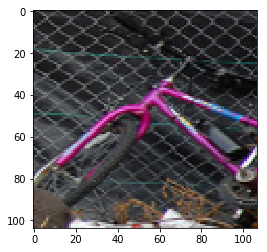

In [17]:
fig,ax = plt.subplots(1)
ax.imshow(images_train_stack[1])
print(images_train_stack.shape)

In [178]:
import argparse

import azureml.core
from azureml.core import Run
from collections import defaultdict
import itertools
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
import keras
from random import shuffle, seed
from skimage.transform import resize
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Flatten, Dropout, GaussianNoise, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def preProcessImage(img):
    img = np.asarray(img)
    return img

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations

 
def constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, dropout, num_classes, x_train):
    percent_noise = 0.1
    noise = (1.0/255) * percent_noise
    model = Sequential()
    model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
    model.add(Conv2D(layer_size, (kernel_size, kernel_size)))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for l in range(conv_layer-1):
        model.add(Conv2D(layer_size, (kernel_size, kernel_size)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Flatten())

    for j in range(dense_layer):
        model.add(Dense(dense_size))
        model.add(Activation('relu'))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])#, 'recall', 'precision', 'fmeasure'])

    return model

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    seed(42)
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list

def equalClassSizes(annotations, number_instances, path):
    bounded_images = []
    bounded_annotations = []
    image_ids = []
    instance_counts = [0] * 91
    try:
        for annotation in annotations:
            if instance_counts[annotation['category_id']] < number_instances:
                instance_counts[annotation['category_id']] +=1
                print(instance_counts)
                image_id = annotation['image_id']
                image_id_string = str(image_id).zfill(12)
                image = Image.open(path + image_id_string +'.jpg').convert('RGB')
                image = preProcessImage(image) 
                image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                       , (104, 107),
                               anti_aliasing=True)
                bounded_images.append(image_resized)
                bounded_annotations.append(annotation['category_id'])   
                image_ids.append(image_id)
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    image_ids = np.asarray(image_ids)
    return image_ids,bounded_images,bounded_annotations
        
path = "data/train2014/COCO_train2014_"


In [169]:
with open(os.path.join(data_folder, "annotations/instances_train2014.json")) as read_file:
    train = json.load(read_file)

train_annotations = train["annotations"]

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x000002A1FD73A730>
Traceback (most recent call last):
  File "c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\_weakrefset.py", line 39, in _remove
    self = selfref()
KeyboardInterrupt


In [181]:
random_images_bboxes = equalClassSizes(train_annotations,10, path)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 7, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 8, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 9, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0,

[0, 0, 10, 10, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, 10, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, 10, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 0, 10, 10, 10, 10, 10, 10, 0, 1, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, 10, 10, 10, 10, 10, 0, 2, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, 10, 10, 10, 10, 10, 0, 3, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, 10, 10, 10, 10, 10, 0, 4, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 

[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10,

[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 

[0, 10, 10, 10, 10, 10, 10, 10, 4, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 5, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 6, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 7, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 5, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 6, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 7, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 8, 0, 10, 10, 10, 10,

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 1

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 8, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 9, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 8, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 9, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10,

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 5, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 6, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 7, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 1, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 2, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 7, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 5, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 6, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 7, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0,

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 2, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 3, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 4, 10, 0, 0, 0, 0, 10, 0, 

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 1, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 2, 0

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 6, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 7, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 5, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 6, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 

In [ ]:
print(random_images_bboxes)
image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)

In [179]:
train_categories = np.zeros(100, dtype=object)
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
train_categories = train_categories[train_categories != 0]
del train_categories
'''
labels = np.asarray(list(itemsets.values()))

keys = np.asarray(list(itemsets.keys()))
del itemsets

rand_sets,rand_images = random_sets(labels,keys,500)
del labels
del keys

random_images_bboxes = []
random_images_bboxes_val = []
for imageset in rand_images[0:1]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
for image in rand_images[1:2]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes_val.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
print("bboxes finished")
del rand_images
'''
random_images_bboxes = equalClassSizes(train_annotations,10, path)
random_images_bboxes_val = equalClassSizes(train_annotations,10, path)
image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
del image_id_train
del random_images_bboxes
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
del image_id_val
del random_images_bboxes_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val
x_train = images_train_stack/255
x_test = images_val_stack/255
print("divided by 255")

corrected_ids = [-1,0,1,2,3,4,5,6,7,8,9,10,-1,11,12,13,14,15,16,17,18,19,20,21,22,23,-1,24,25,-1,-1,26,27,28,29,30,31,32,33,34,35,36,37,38,39,-1,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,-1,60,-1,-1,61,-1,62,63,64,65,66,67,68,69,70,71,72,-1,73,74,75,76,77,78,79]
for index, item in enumerate(bounded_annotations_train):
    bounded_annotations_train[index] = corrected_ids[bounded_annotations_train[index]]
for index, item in enumerate(bounded_annotations_val):
    bounded_annotations_val[index] = corrected_ids[bounded_annotations_val[index]]
ylabels_train = to_categorical(bounded_annotations_train)
ylabels_test = to_categorical(bounded_annotations_val)
print("to_categorical")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 5, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 6, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 7, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0,

[0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 0, 10, 10, 10, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, 10, 10, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, 10, 10, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, 10, 10, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 3, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 4, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 5, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 6, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0,

[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 7, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 8, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 9, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 

[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 8, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 9, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0,

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 0, 10, 0, 0, 10, 10, 10, 10, 10,

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10,

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 5, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 6, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 8, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 9, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 7, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 8, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 9, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 4, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 5, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 6, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10,

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 1, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 2, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 1, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 2, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 6, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 7, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0,

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 9, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 1, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 4, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 5, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 6, 0, 0, 0, 10, 

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 8, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 9, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 0, 5, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 0, 6, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 0, 0, 7, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10,

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 9, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 1, 10, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 

[0, 0, 10, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 0, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, 10, 10, 10, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, 10, 10, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, 10, 10, 10, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 3, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 4, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 5, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 6, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0,

[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 

[0, 10, 10, 10, 10, 10, 10, 10, 7, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 8, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 9, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 0,

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 4, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 5, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 6, 0, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 7, 0, 10, 10, 10, 10,

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 1, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 1, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 2, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 3, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 9, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 1, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 6, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 7, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 4, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 5, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 6, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 1

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 1, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 2, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 1

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 5, 0, 10, 0, 0, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 5, 0, 10, 10, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0,

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 4, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 5, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 6, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0,

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 6, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 7, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 8, 10, 0, 0, 0, 0, 10, 0, 

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 9, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10,

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 1, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 2, 0, 0, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 1, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10]
[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 2, 10, 0, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 0, 0, 10, 0, 10, 10, 10, 10, 10, 10

ValueError: too many values to unpack (expected 3)

In [139]:
with tf.Session() as session:
    sess.run(tf.global_variables_initializer())
    early_stopping_monitor = EarlyStopping(patience = 3)
    np.set_printoptions(threshold=np.inf)
    dense_layers = [3]
    layer_sizes = [64]
    dense_sizes = [64]
    conv_layers = [3]
    kernel_sizes = [3]
    for dense_layer in dense_layers:
        for dense_size in dense_sizes:
            for kernel_size in kernel_sizes:
                for layer_size in layer_sizes:
                    for conv_layer in conv_layers:
                        model = constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, True, len(ylabels_train[0]), x_train)
                        NAME = "{}-conv-{}-nodes-{}-dense-{}-dense_size-{}-kernel".format(conv_layer, layer_size, dense_layer, dense_size, kernel_size)
                        print(NAME)
                        tensorboard = TensorBoard(log_dir="outputs/{}".format(NAME))
                        model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=1, validation_data = (x_test, ylabels_test), callbacks = [tensorboard],shuffle=True)
                        y_pred = model.predict(x_test)

                        #print(y_pred)
                        y_pred_rounded = (y_pred > 0.5)
                        #print(y_pred_rounded)
                        #confusion = tf.confusion_matrix(labels=ylabels_test, predictions=y_pred_rounded)
                        #print(confusion)
                        predictions = tf.argmax(y_pred,1)
                        true_class = tf.argmax(ylabels_test, 1)
                        con_mat = tf.confusion_matrix(true_class, predictions)
                        print('Confusion Matrix: \n\n', tf.Tensor.eval(con_mat,feed_dict=None, session=None))
                        #cm = confusion_matrix(ylabels_test, list(predictions))
                        #print(cm)
                        '''
                        model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                        epochs=10, callbacks = [tensorboard], validation_data = datagen_test.flow(x_test, ylabels_test, shuffle=True))
                        confusion = tf.confusion_matrix(labels=y_, predictions=y, num_classes=num_classes)
                        '''
                        #model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
                        model.save('outputs/model.h5')
    '''
    percent_noise = 0.1
    noise = (1.0/255) * percent_noise
    model = Sequential()
    model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(8))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

    print("2x3x3x128,2x3x3x64,0.25,D64,0.25 model.fit")
    model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                        epochs=100, callbacks = [], validation_data = datagen_test.flow(x_test, ylabels_test, shuffle=True))
    '''

3-conv-64-nodes-3-dense-64-dense_size-3-kernel
Train on 1347 samples, validate on 1347 samples
1347/1347 [==============================] - 79s 58ms/sample - loss: 4.1262 - acc: 0.1886 - val_loss: 3.7346 - val_acc: 0.2851
Confusion Matrix: 

 [[384   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  6   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [ 63   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0

In [135]:
with tf.Session() as session:
    sess.run(tf.global_variables_initializer())
    print('Confusion Matrix: \n\n', tf.Tensor.eval(con_mat,feed_dict=None, session=None))

Confusion Matrix: 

 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0 384   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0

In [143]:
print(train_annotations[0])

{'segmentation': [[312.29, 562.89, 402.25, 511.49, 400.96, 425.38, 398.39, 372.69, 388.11, 332.85, 318.71, 325.14, 295.58, 305.86, 269.88, 314.86, 258.31, 337.99, 217.19, 321.29, 182.49, 343.13, 141.37, 348.27, 132.37, 358.55, 159.36, 377.83, 116.95, 421.53, 167.07, 499.92, 232.61, 560.32, 300.72, 571.89]], 'area': 54652.9556, 'iscrowd': 0, 'image_id': 480023, 'bbox': [116.95, 305.86, 285.3, 266.03], 'category_id': 58, 'id': 86}
